In [1]:
#Import Necessary Libraries
import pandas as pd
import numpy as np
import nltk
import textstat
#nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from textstat.textstat import textstat
from matplotlib.table import Table
from scipy.stats import multivariate_normal, invwishart
from abc import ABC, abstractmethod
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [2]:
df = pd.read_csv('training_main_dataset.csv')
test_df = pd.read_csv('exp_test.csv')

In [3]:
df

index     author                                               text  \
0        1  John Nery  The success of the Marcos-Duterte electoral al...   
1        2  John Nery  The war on Ninoy Aquino‚Äôs legacy is a fight th...   
2        3  John Nery  One of many lessons from the ongoing Twitter f...   
3        4  John Nery  Of course we all need to be particular about t...   
4        5  John Nery  In 'Some People Need Killing,' the acclaimed j...   
..     ...        ...                                                ...   
195    196    Copilot  The concept of federalism has been a topic of ...   
196    197    Copilot  Election campaign financial transparency is a ...   
197    198    Copilot  Mental health stigma remains a significant bar...   
198    199    Copilot  The Philippines, a nation known for its vibran...   
199    200    Copilot  Plastic pollution is a pressing environmental ...   

     ai_label  
0           0  
1           0  
2           0  
3           0  
4           0  
..        ...  
195         1  
196         1  
197         1  
198         1  
199         1  

[200 rows x 4 columns]

In [4]:
#test_df

In [5]:
def preprocess_text(text):
    # Convert to lowercase
    return text.lower()

# Helper function to calculate complex sentence ratio
def count_clauses(sentence):
    # A simple approximation using commas, semicolons, and conjunctions
    return sentence.count(',') + sentence.count(';') + sentence.lower().count('and') + sentence.lower().count('but')

# Feature extraction function
def extract_features(text):
    # Tokenize words and sentences
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    # Basic metrics
    word_count = len([word for word in words if word.isalpha()])
    avg_word_length = np.mean([len(word) for word in words if word.isalpha()]) if word_count > 0 else 0
    avg_sentence_length = word_count / len(sentences) if len(sentences) > 0 else 0

    # Punctuation metrics
    punctuation_count = sum(1 for char in text if char in ['.', ',', ':', ';', '?', '!', '-', '\'', '\"'])
    punctuation_ratio = punctuation_count / word_count if word_count > 0 else 0
    avg_punctuation_per_sentence = punctuation_count / len(sentences) if len(sentences) > 0 else 0

    # Linguistic diversity features
    vocab_size = len(set([word for word in words if word.isalpha()]))
    vocab_ratio = vocab_size / word_count if word_count > 0 else 0

    # Readability metrics
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    gunning_fog = textstat.gunning_fog(text)
    smog_index = textstat.smog_index(text)
    cl_index = textstat.coleman_liau_index(text)

    # Sentence complexity metrics
    total_clauses = sum(count_clauses(sentence) for sentence in sentences)
    avg_clauses_per_sentence = total_clauses / len(sentences) if len(sentences) > 0 else 0
    complex_sentence_ratio = sum(1 for sentence in sentences if count_clauses(sentence) > 1) / len(sentences) if len(sentences) > 0 else 0

    # Lexical density
    pos_tags = pos_tag(words)
    content_words = [word for word, pos in pos_tags if pos.startswith(('NN', 'VB', 'JJ', 'RB'))]
    lexical_density = len(content_words) / word_count if word_count > 0 else 0

    return {
        'word_count': word_count,
        'sentence_count': len(sentences),
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length,
        'punctuation_count': punctuation_count,
        'punctuation_ratio': punctuation_ratio,
        'avg_punctuation_per_sentence': avg_punctuation_per_sentence,
        'vocab_size': vocab_size,
        'vocab_ratio': vocab_ratio,
        'flesch_reading_ease': flesch_reading_ease,
        'gunning_fog': gunning_fog,
        'smog_index': smog_index,
        'coleman_liau_index': cl_index,
        'avg_clauses_per_sentence': avg_clauses_per_sentence,
        'complex_sentence_ratio': complex_sentence_ratio,
        'lexical_density': lexical_density
    }

# Apply preprocessing and feature extraction to each text sample
def preprocess_and_extract_features(df):
    df['preprocessed_text'] = df['text'].apply(preprocess_text)
    df_features = df.apply(lambda row: extract_features(row['preprocessed_text']), axis=1).apply(pd.Series)
    return pd.concat([df[['index', 'label']], df_features], axis=1)

In [6]:
#Apply preprocessing and feature extraction to each text sample
df['preprocessed_text'] = df['text'].apply(preprocess_text)
df_features = df.apply(lambda row: extract_features(row['preprocessed_text']), axis=1).apply(pd.Series)
df = pd.concat([df, df_features], axis=1)

In [7]:
# Define features (X) and target (y)
X = df[['word_count', 'avg_word_length', 'avg_sentence_length',
        'punctuation_ratio', 'avg_punctuation_per_sentence', 'vocab_size', 'vocab_ratio', 
        'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
        'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']]
y = df['author']

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Set up k-fold cross-validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Track metrics across folds
accuracies = []
classification_reports = []

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    # Split the dataset into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    # Collect classification report for the fold
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports.append(report)
    
    # Print fold-specific metrics
    print(f"Fold {fold} Accuracy: {accuracy:.2f}")
    print(f"Fold {fold} Classification Report:")
    print(classification_report(y_test, y_pred))

# Calculate overall metrics
mean_accuracy = np.mean(accuracies)
print(f"\nOverall Cross-Validation Accuracy: {mean_accuracy:.2f}")

Fold 1 Accuracy: 0.50
Fold 1 Classification Report:
                     precision    recall  f1-score   support

            Copilot       0.25      0.50      0.33         2
 Diwa C. Guinigundo       1.00      0.56      0.71         9
         GPT4o-mini       0.67      0.67      0.67         6
    Gemini1.5-flash       0.25      0.20      0.22         5
      Iris Gonzales       0.00      0.00      0.00         1
          John Nery       0.60      0.75      0.67         4
Jose Ma Montelibano       0.67      0.50      0.57         4
           Llama3.2       0.40      0.50      0.44         4
     Maria A. Ressa       1.00      0.33      0.50         3
      Phind Instant       1.00      0.50      0.67         2

           accuracy                           0.50        40
          macro avg       0.58      0.45      0.48        40
       weighted avg       0.66      0.50      0.54        40

Fold 2 Accuracy: 0.78
Fold 2 Classification Report:
                     precision    recal

C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fold 5 Accuracy: 0.80
Fold 5 Classification Report:
                     precision    recall  f1-score   support

            Copilot       0.75      1.00      0.86         6
 Diwa C. Guinigundo       1.00      0.67      0.80         3
         GPT4o-mini       1.00      0.75      0.86         4
    Gemini1.5-flash       0.50      0.25      0.33         4
      Iris Gonzales       1.00      0.67      0.80         3
          John Nery       0.50      1.00      0.67         2
Jose Ma Montelibano       0.80      1.00      0.89         4
           Llama3.2       0.67      0.67      0.67         3
     Maria A. Ressa       0.83      0.83      0.83         6
      Phind Instant       1.00      1.00      1.00         5

           accuracy                           0.80        40
          macro avg       0.81      0.78      0.77        40
       weighted avg       0.82      0.80      0.79        40


Overall Cross-Validation Accuracy: 0.64


In [8]:
# Model Preparation
X_test = test_df.drop(['index', 'label'], axis=1)
y_test = test_df['label']

In [9]:
def classify_new_text(new_text, model):
    # Preprocess the text and extract features
    preprocessed_text = preprocess_text(new_text)
    new_features = extract_features(preprocessed_text)
    new_features_df = pd.DataFrame([new_features])

    # Reindex using the cleaned X_train's columns
    new_features_df = new_features_df.reindex(columns=X_train.columns)

    # Handle any NaN values
    new_features_df = new_features_df.fillna(0)

    # Predict the author
    predicted_author = model.predict(new_features_df)
    return predicted_author[0]

In [10]:
# Function to extract features and store them into a DataFrame
def extract_features_as_df(text):
    # Call the existing extract_features function
    raw_features = extract_features(text)
    
    # Convert the features to a DataFrame with two columns: Feature and Value
    features_df = pd.DataFrame(list(raw_features.items()), columns=['Feature', 'Value'])
    
    return features_df

def extract_features_for_csv(df):
    feature_dfs = df['text'].apply(extract_features_as_df)
    
    # Concatenate all the feature DataFrames into a single DataFrame
    all_features = pd.concat(feature_dfs.tolist(), ignore_index=True)
    
    # Concatenate the extracted features with the original DataFrame
    df_features = pd.concat([df, all_features], axis=1)
    
    # Remove rows with any NaN values
    df_features_cleaned = df_features.dropna()
    
    return df_features_cleaned

df_features = extract_features_for_csv(df)
df_features

index     author                                               text  \
0      1.0  John Nery  The success of the Marcos-Duterte electoral al...   
1      2.0  John Nery  The war on Ninoy Aquino‚Äôs legacy is a fight th...   
2      3.0  John Nery  One of many lessons from the ongoing Twitter f...   
3      4.0  John Nery  Of course we all need to be particular about t...   
4      5.0  John Nery  In 'Some People Need Killing,' the acclaimed j...   
..     ...        ...                                                ...   
195  196.0    Copilot  The concept of federalism has been a topic of ...   
196  197.0    Copilot  Election campaign financial transparency is a ...   
197  198.0    Copilot  Mental health stigma remains a significant bar...   
198  199.0    Copilot  The Philippines, a nation known for its vibran...   
199  200.0    Copilot  Plastic pollution is a pressing environmental ...   

     ai_label                                  preprocessed_text  word_count  \
0         0.0  the success of the marcos-duterte electoral al...      1558.0   
1         0.0  the war on ninoy aquino‚Äôs legacy is a fight th...      1475.0   
2         0.0  one of many lessons from the ongoing twitter f...       851.0   
3         0.0  of course we all need to be particular about t...       996.0   
4         0.0  in 'some people need killing,' the acclaimed j...      1800.0   
..        ...                                                ...         ...   
195       1.0  the concept of federalism has been a topic of ...      1031.0   
196       1.0  election campaign financial transparency is a ...       907.0   
197       1.0  mental health stigma remains a significant bar...       886.0   
198       1.0  the philippines, a nation known for its vibran...      1045.0   
199       1.0  plastic pollution is a pressing environmental ...       984.0   

     sentence_count  avg_word_length  avg_sentence_length  punctuation_count  \
0              65.0         4.835045            23.969231              179.0   
1              56.0         4.792542            26.339286              174.0   
2              39.0         4.659224            21.820513              117.0   
3              40.0         4.618474            24.900000              109.0   
4              73.0         4.695000            24.657534              274.0   
..              ...              ...                  ...                ...   
195            49.0         6.068865            21.040816              145.0   
196            46.0         6.123484            19.717391              102.0   
197            48.0         5.678330            18.458333              107.0   
198            56.0         5.992344            18.660714              147.0   
199            47.0         5.949187            20.936170              153.0   

     ...  vocab_ratio  flesch_reading_ease  gunning_fog  smog_index  \
0    ...     0.391528                47.32        13.13        13.8   
1    ...     0.395932                54.66        13.13        13.4   
2    ...     0.453584                67.28        11.03        11.1   
3    ...     0.391566                57.20        12.12        13.1   
4    ...     0.402222                59.53        11.04        11.8   
..   ...          ...                  ...          ...         ...   
195  ...     0.371484                16.52        13.77        17.0   
196  ...     0.382580                26.20        13.60        15.8   
197  ...     0.382619                35.37        12.01        13.9   
198  ...     0.402871                27.52        12.79        15.5   
199  ...     0.377033                24.37        13.66        16.4   

     coleman_liau_index  avg_clauses_per_sentence  complex_sentence_ratio  \
0                 11.78                  2.000000                0.523077   
1                 11.09                  2.589286                0.625000   
2                 10.21                  2.256410                0.487179   
3    

In [11]:
# Feature normalization ranges
feature_ranges = {
    'word_count': (0, 10000),  # Adjust as needed
    'sentence_count': (0, 1000),  # Adjust as needed
    'avg_word_length': (1, 10),  # Average word length typically ranges from 1 to 10 characters
    'avg_sentence_length': (0, 100),  # Average sentence length in words
    'punctuation_count': (0, 1000),  # Total punctuation marks, adjust as needed
    'punctuation_ratio': (0, 1),  # Ratio of punctuation marks per character
    'avg_punctuation_per_sentence': (0, 10),  # Adjust based on expected punctuation per sentence
    'vocab_size': (0, 1000),  # Vocabulary size, adjust as needed
    'vocab_ratio': (0, 1),  # Vocabulary ratio
    'flesch_reading_ease': (0, 100),  # Flesch reading ease score
    'gunning_fog': (6, 17),  # Gunning-Fog Index
    'smog_index': (6, 17),  # SMOG Index
    'coleman_liau_index': (5, 17),  # Coleman-Liau Index
    'avg_clauses_per_sentence': (0, 10),  # Average number of clauses per sentence
    'complex_sentence_ratio': (0, 1),  # Ratio of complex sentences
    'lexical_density': (0, 1)  # Lexical density
}

def normalize_feature(value, feature_name, feature_ranges):
    """Normalize a single feature value based on its predefined range."""
    if feature_name in feature_ranges:
        min_val, max_val = feature_ranges[feature_name]
        if max_val - min_val == 0:  # Avoid division by zero
            return 0
        return (value - min_val) / (max_val - min_val)
    else:
        raise ValueError(f"Feature '{feature_name}' does not have defined normalization ranges.")

def extract_and_normalize_features_as_df(text, feature_ranges):
    """Extract features, normalize them, and return as a DataFrame with normalized columns."""
    # Extract features into a DataFrame
    features_df = extract_features_as_df(text)

    # Check for empty or missing data
    if features_df.empty:
        print("No features extracted for the text. Returning an empty DataFrame.")
        return pd.DataFrame()  # Return an empty DataFrame for consistency

    # Create a dictionary to store normalized values
    normalized_data = {}

    for _, row in features_df.iterrows():
        feature_name = row['Feature']
        raw_value = row['Value']

        if feature_name in feature_ranges:
            # Normalize the feature value and add it as a new column
            normalized_data[f"{feature_name}_normalized"] = normalize_feature(raw_value, feature_name, feature_ranges)
        else:
            print(f"Feature '{feature_name}' not found in feature_ranges. Skipping normalization.")

    # Convert normalized data to a DataFrame
    normalized_df = pd.DataFrame([normalized_data])
    return normalized_df

def extract_and_normalize_features_for_csv(df, feature_ranges):
    """Extract and normalize features for the entire dataset."""
    # Initialize a list to store normalized DataFrames for each text
    normalized_dfs = []

    for text in df['text']:
        normalized_df = extract_and_normalize_features_as_df(text, feature_ranges)
        normalized_dfs.append(normalized_df)

    # Concatenate all normalized DataFrames into a single DataFrame
    all_normalized_features = pd.concat(normalized_dfs, ignore_index=True)

    # Add the normalized columns to the original DataFrame
    df_features = pd.concat([df.reset_index(drop=True), all_normalized_features.reset_index(drop=True)], axis=1)

    # Drop rows with NaN values if any normalized feature is missing
    df_features_cleaned = df_features.dropna()

    return df_features_cleaned

In [12]:
# Extract and normalize features for the dataset
df_normalized_features = extract_and_normalize_features_for_csv(df, feature_ranges)

# Display the normalized DataFrame
df_normalized_features

index     author                                               text  \
0        1  John Nery  The success of the Marcos-Duterte electoral al...   
1        2  John Nery  The war on Ninoy Aquino‚Äôs legacy is a fight th...   
2        3  John Nery  One of many lessons from the ongoing Twitter f...   
3        4  John Nery  Of course we all need to be particular about t...   
4        5  John Nery  In 'Some People Need Killing,' the acclaimed j...   
..     ...        ...                                                ...   
195    196    Copilot  The concept of federalism has been a topic of ...   
196    197    Copilot  Election campaign financial transparency is a ...   
197    198    Copilot  Mental health stigma remains a significant bar...   
198    199    Copilot  The Philippines, a nation known for its vibran...   
199    200    Copilot  Plastic pollution is a pressing environmental ...   

     ai_label                                  preprocessed_text  word_count  \
0           0  the success of the marcos-duterte electoral al...      1558.0   
1           0  the war on ninoy aquino‚Äôs legacy is a fight th...      1475.0   
2           0  one of many lessons from the ongoing twitter f...       851.0   
3           0  of course we all need to be particular about t...       996.0   
4           0  in 'some people need killing,' the acclaimed j...      1800.0   
..        ...                                                ...         ...   
195         1  the concept of federalism has been a topic of ...      1031.0   
196         1  election campaign financial transparency is a ...       907.0   
197         1  mental health stigma remains a significant bar...       886.0   
198         1  the philippines, a nation known for its vibran...      1045.0   
199         1  plastic pollution is a pressing environmental ...       984.0   

     sentence_count  avg_word_length  avg_sentence_length  punctuation_count  \
0              65.0         4.835045            23.969231              179.0   
1              56.0         4.792542            26.339286              174.0   
2              39.0         4.659224            21.820513              117.0   
3              40.0         4.618474            24.900000              109.0   
4              73.0         4.695000            24.657534              274.0   
..              ...              ...                  ...                ...   
195            49.0         6.068865            21.040816              145.0   
196            46.0         6.123484            19.717391              102.0   
197            48.0         5.678330            18.458333              107.0   
198            56.0         5.992344            18.660714              147.0   
199            47.0         5.949187            20.936170              153.0   

     ...  avg_punctuation_per_sentence_normalized  vocab_size_normalized  \
0    ...                                 0.263235                  0.644   
1    ...                                 0.310714                  0.615   
2    ...                                 0.292500                  0.409   
3    ...                                 0.272500                  0.412   
4    ...                                 0.375342                  0.769   
..   ...                                      ...                    ...   
195  ...                                 0.290000                  0.426   
196  ...                                 0.217021                  0.388   
197  ...                                 0.222917                  0.380   
198  ...                                 0.257895                  0.481   
199  ...                                 0.325532                  0.420   

     vocab_ratio_normalized  flesch_reading_ease_normalized  \
0                  0.413350                          0.4732   
1                  0.416949                          0.5466   
2                  0.480611                          0.6728   
3

In [13]:
# Function to extract stylometric features for BOCPD
def extract_stylometric_features_for_bocpd(new_text):
    preprocessed_text = preprocess_text(new_text)
    features = extract_features(preprocessed_text)
    return features

In [14]:
# Hazard function
def constant_hazard(lam, t):
    return 1 / lam

# Predictive model (Gaussian)
class MultivariateGaussianPredictiveModel:
    def __init__(self, mu0, kappa0=1, alpha0=1, beta0=None):
        # mu0 is a vector for the mean of the prior
        # beta0 is a matrix for the covariance of the prior
        self.mu0 = np.array(mu0)
        self.kappa0 = kappa0
        self.alpha0 = alpha0
        self.beta0 = beta0 if beta0 is not None else np.eye(len(mu0))  # Identity matrix if not provided
        
        # Initialize posterior parameters
        self.mu = np.array(mu0)
        self.kappa = kappa0
        self.alpha = alpha0
        self.beta = np.array(self.beta0)

    def update(self, x):
        x = np.array(x)
        self.kappa += 1
        self.mu = (self.kappa * self.mu0 + x) / (self.kappa + 1)
        diff = x - self.mu0
        self.beta += 0.5 * np.outer(diff, diff)  # Update covariance
        self.alpha += 0.5

    def log_predictive(self, x):
        d = len(self.mu0)  # Dimensionality
        x = np.array(x)

        # Covariance matrix for predictive distribution
        cov_matrix = (self.beta * (self.kappa + 1)) / (self.alpha * self.kappa)
    
        # Regularize the covariance matrix
        cov_matrix += np.eye(d) * 1e-6  # Add small value to diagonal

        try:
            cov_det = np.linalg.det(cov_matrix)
            cov_inv = np.linalg.inv(cov_matrix)

            # Multivariate Gaussian log probability
            log_prob = -0.5 * d * np.log(2 * np.pi) - 0.5 * np.log(cov_det) - \
                       0.5 * np.dot((x - self.mu).T, np.dot(cov_inv, (x - self.mu)))
            return log_prob
        except np.linalg.LinAlgError:
            print("Covariance matrix is singular. Returning -inf for log probability.")
            return -np.inf  # Return a very low log probability

# Bayesian Online Change Point Detection algorithm
def bocpd(data, hazard_func, predictive_model):
    T = len(data)
    P = np.zeros((T+1, T+1))
    P[0, 0] = 1
    
    max_run_length = []
    
    for t in range(1, T+1):
        hazard = hazard_func(t)
        log_pred_prob = np.array([predictive_model.log_predictive(data[t-1]) for _ in range(t)])
        P[t, 1:t+1] = P[t-1, :t] * np.exp(log_pred_prob) * (1 - hazard)
        P[t, 0] = np.sum(P[t-1, :t] * hazard)
        P[t, :t+1] /= np.sum(P[t, :t+1])
        predictive_model.update(data[t-1])
        max_run_length.append(np.argmax(P[t, :t+1]))
    
    return P, max_run_length

# Detect change points
def detect_change_points(run_length_probs):
    change_points = []
    for t, prob in enumerate(run_length_probs):
        if prob == 0:  # Run length resets, indicating a change
            change_points.append(t)
    return change_points


In [15]:
def display_table_with_white_background(dataframe, title):
    # Round numeric values to 2 decimal places
    dataframe = dataframe.round(2)

    fig, ax = plt.subplots(figsize=(12, 4))  # Adjust size as needed
    ax.axis('off')

    table = Table(ax, bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)  # This will set the default font size for the table

    # Set column width and cell height
    col_width = 1.5
    row_height = 0.4
    num_rows, num_cols = dataframe.shape

    # Add table headers
    for i, column in enumerate(dataframe.columns):
        cell = table.add_cell(0, i, width=col_width, height=row_height, text=column, loc='center', facecolor='white', edgecolor='black')
        cell._text.set_fontsize(12)  # Set font size for header

    # Add table data
    for i, row in dataframe.iterrows():
        for j, value in enumerate(row):
            cell = table.add_cell(i + 1, j, width=col_width, height=row_height, text=f"{value:.2f}" if isinstance(value, (int, float)) else value, loc='center', facecolor='white', edgecolor='black')
            cell._text.set_fontsize(10)  # Set font size for data

    ax.add_table(table)
    plt.title(title, fontsize=14, pad=20)
    plt.show()

In [16]:
def detect_change_points_in_text(new_text, author, trained_model):
    # Preprocess and extract features for the new text
    features = extract_features(preprocess_text(new_text))
    
    features_df = pd.DataFrame([features])
    features_df = features_df[['word_count', 'avg_word_length', 'avg_sentence_length',
        'punctuation_ratio', 'avg_punctuation_per_sentence', 'vocab_size', 'vocab_ratio', 
        'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
        'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']]
    
    predicted_author = trained_model.predict(features_df)

    print(f"Provided Author: {author}")
    print(f"Predicted Author: {predicted_author}")
    
    if predicted_author[0] != author:
        print(f"Warning: The provided author does not match the predicted author. Using provided author '{author}' for analysis. Predicted author is: '{predicted_author}'")

    sentences = sent_tokenize(new_text)
    num_sentences = len(sentences)
    
    print(f"Number of sentences in new_text: {num_sentences}")
    
    # Extract stylometric features for each sentence
    sentences = sent_tokenize(new_text)
    sentence_features = []
    
    for sentence in sentences:
        preprocessed_sentence = preprocess_text(sentence)
        sentence_feature = extract_features(preprocessed_sentence)
        
        selected_features = [
            sentence_feature['avg_word_length'], 
            sentence_feature['avg_sentence_length'], 
            sentence_feature['punctuation_ratio'], 
            sentence_feature['vocab_ratio'],
            sentence_feature['flesch_reading_ease'],
            sentence_feature['gunning_fog'],
            sentence_feature['smog_index'],
            sentence_feature['coleman_liau_index'],
            sentence_feature['avg_clauses_per_sentence'],
            sentence_feature['complex_sentence_ratio'],
            sentence_feature['lexical_density']
        ]
        sentence_features.append(selected_features)
    
    sentence_features = np.array(sentence_features)
    
    # Initialize BOCPD model for multivariate data
    hazard_func = lambda t: constant_hazard(250, t)
    initial_mean = np.mean(sentence_features, axis=0)
    initial_covariance = np.cov(sentence_features, rowvar=False)  # Initial covariance matrix
    
    predictive_model = MultivariateGaussianPredictiveModel(mu0=initial_mean, beta0=initial_covariance)
    
    # Run BOCPD on all selected features (multivariate analysis)
    P, max_run_length = bocpd(sentence_features, hazard_func, predictive_model)

    # Detect change points
    changepoints = detect_change_points(max_run_length)
    
    feature_categories = {
        'Phraseology': ['avg_word_length', 'avg_sentence_length', 'avg_clauses_per_sentence'],
        'Punctuation': ['punctuation_ratio'],
        'Linguistic Diversity': ['vocab_ratio', 'lexical_density', 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index', 'complex_sentence_ratio'],
    }
    
    explanations = []
    changepoint_data = []  # List to collect data for DataFrame
    
    # Initialize counters for category changes
    category_changes = {category: set() for category in feature_categories.keys()}
    
    for idx in changepoints:
        if idx > 0 and idx < len(sentences):
            prev_features = sentence_features[idx - 1]
            curr_features = sentence_features[idx]
            
            feature_changes = []
            category_change_sums = {category: [] for category in feature_categories.keys()}  # Collect values for averaging
            
            for i, feature_name in enumerate(
                ['avg_word_length', 'avg_sentence_length', 'punctuation_ratio', 'vocab_ratio',
                 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
                 'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']):
                
                change = curr_features[i] - prev_features[i]
                
                if change > 0:  # Process only positive changes
                    category = next((cat for cat, features in feature_categories.items() if feature_name in features), None)
    
                    if category:
                        category_changes[category].add(idx)
    
                        # Normalize change and ensure non-negative value
                        normalized_change = max(normalize_feature(change, feature_name, feature_ranges), 0)
    
                        feature_changes.append({
                            'Feature': feature_name,
                            'Change Value': normalized_change,
                            'Category': category
                        })
                        
                        category_change_sums[category].append(normalized_change)  # Store change values for averaging
                        
                        # Add row to changepoint data
                        changepoint_data.append({
                            'Sentence Index': idx,
                            'Sentence': sentences[idx],
                            'Feature': feature_name,
                            'Change Value': normalized_change,
                            'Category': category
                        })
        
            if feature_changes:  # Only add explanations if there are valid positive changes
                explanation = {
                    'sentence': sentences[idx],
                    'feature_changes': feature_changes
                }
                
                # Calculate category-wise averages for this specific explanation
                category_averages = {}
                for category, values in category_change_sums.items():
                    if values:  # Ensure there are values before averaging
                        category_averages[category] = sum(values) / len(values)
    
                explanation['category_averages'] = category_averages  # Store averages
                
                # Compute the overall average for this explanation
                if category_averages:
                    overall_explanation_avg = sum(category_averages.values()) / len(category_averages)
                    explanation['overall_explanation_avg'] = overall_explanation_avg  # Store it in the explanation
                    
                explanations.append(explanation)

    # Create DataFrame from collected changepoint data
    changepoint_df = pd.DataFrame(changepoint_data)
    if not changepoint_df.empty:  # Check if the DataFrame is non-empty
        average_changes = (
            changepoint_df.groupby('Category')['Change Value']
            .mean()
            .reset_index()
            .rename(columns={'Change Value': 'Average Change Value'})
        )
        
        print("\n--- Average Normalized Change Value by Category ---")
        print(average_changes)
    else:
        print("No change points detected; no averages to calculate.") 

    # Summarize the average changes across all categories
    overall_mean = average_changes['Average Change Value'].sum() / 3  # Divide the sum by 3 categories
    print(f"\nOverall Mean of Change Values Across Categories: {overall_mean:.4f}")

    # Determine if the text is AI-generated based on the threshold
    if overall_mean > 0.15:
        print("The text is likely human-written.")
    elif overall_mean <= 0.15:
        print("The text is likely AI-generated.")
    else:
        print("No change points detected; no averages to calculate.")
    
    print("\n")
    # Display results similarly
    aiSen_count = 0
    HumanSen_count = 0
    for explanation in explanations:
        print(f"\nChange detected in sentence: {explanation['sentence']}")
        print("Feature changes:")
        
        table_data = []
        for feature_change in explanation['feature_changes']:
            table_data.append([
                feature_change['Feature'],
                feature_change['Change Value'],
                feature_change['Category']
            ])
        
        change_table = pd.DataFrame(table_data, columns=['Feature', 'Change Value', 'Category'])
        display_table_with_white_background(change_table, "Change Point Detection of Features for this Sentence")
    
        # Display category-wise averages
        print("\nCategory Averages for this Explanation:")
        for category, avg_value in explanation['category_averages'].items():
            print(f"  {category}: {avg_value:.4f}")
    
        # Display overall explanation average
        if 'overall_explanation_avg' in explanation:
            overall_meanSen = explanation['overall_explanation_avg']
            print(f"\nOverall Average for this Explanation: {overall_meanSen:.4f}")
            
            # AI vs Human classification
            if overall_meanSen > 0.15:
                HumanSen_count+=1
                print("The text is likely human-written.")
            elif overall_meanSen <= 0.15:
                aiSen_count+=1
                print("The text is likely AI-generated.")
            else:
                print("No change points detected; no averages to calculate.")
    print("Human Sentence Count: ", HumanSen_count)
    print("AI Sentence Count: ", aiSen_count)

    return changepoints, explanations, changepoint_df, features_df, overall_mean, predicted_author


Provided Author: John Nery
Predicted Author: ['Diwa C. Guinigundo']
Number of sentences in new_text: 52

--- Average Normalized Change Value by Category ---
               Category  Average Change Value
0  Linguistic Diversity              0.228640
1           Phraseology              0.142527
2           Punctuation              0.113121

Overall Mean of Change Values Across Categories: 0.1614
The text is likely human-written.



Change detected in sentence: Central to the 2025 elections is the escalating tension between the Marcos and Duterte dynasties.
Feature changes:


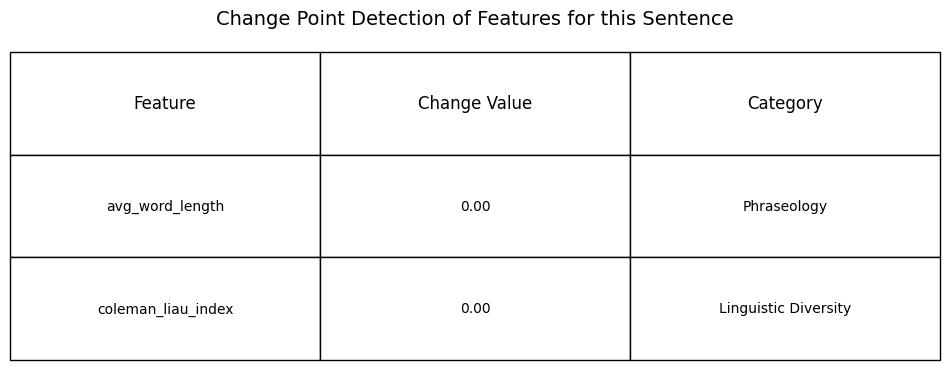


Category Averages for this Explanation:
  Phraseology: 0.0000
  Linguistic Diversity: 0.0000

Overall Average for this Explanation: 0.0000
The text is likely AI-generated.

Change detected in sentence: Once allies, their relationship has deteriorated, leading to a high-stakes political contest.
Feature changes:


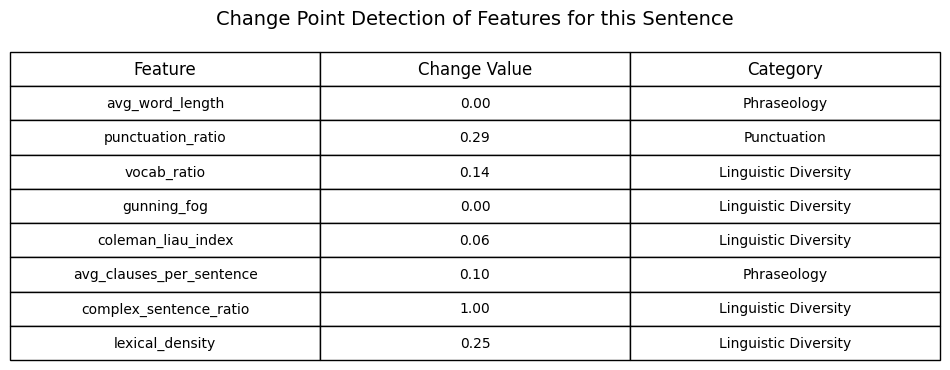


Category Averages for this Explanation:
  Phraseology: 0.0500
  Punctuation: 0.2922
  Linguistic Diversity: 0.2893

Overall Average for this Explanation: 0.2105
The text is likely human-written.

Change detected in sentence: This move is seen as an attempt to reassert his family's influence and challenge President Marcos Jr.'s leadership.
Feature changes:


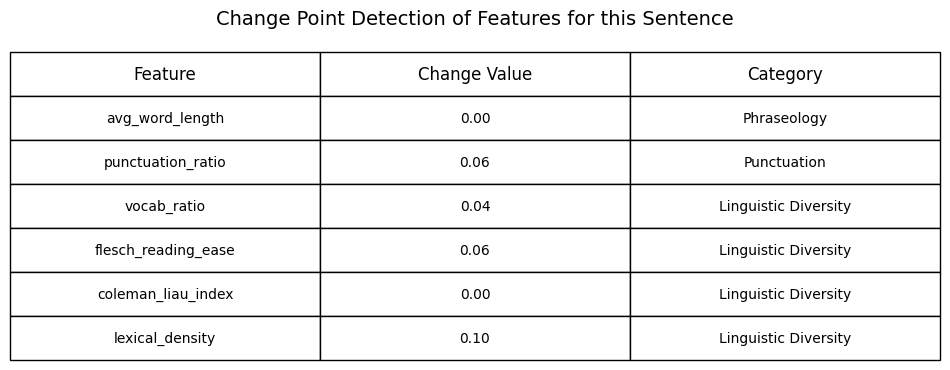


Category Averages for this Explanation:
  Phraseology: 0.0000
  Punctuation: 0.0614
  Linguistic Diversity: 0.0504

Overall Average for this Explanation: 0.0373
The text is likely AI-generated.

Change detected in sentence: The Duterte family's political resurgence is further underscored by the candidacies of Duterte's sons, with speculation that they might seek Senate seats to counterbalance Marcos's authority.
Feature changes:


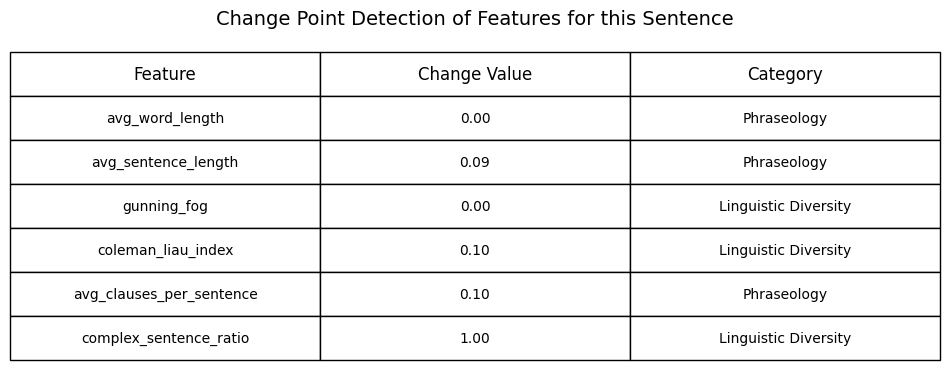


Category Averages for this Explanation:
  Phraseology: 0.0633
  Linguistic Diversity: 0.3672

Overall Average for this Explanation: 0.2153
The text is likely human-written.

Change detected in sentence: This coalition aims to consolidate support for the current administration and presents a formidable force in the upcoming elections.
Feature changes:


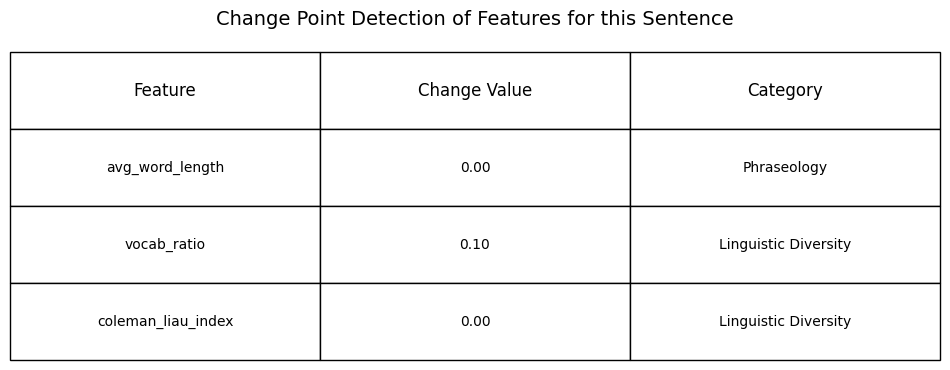


Category Averages for this Explanation:
  Phraseology: 0.0000
  Linguistic Diversity: 0.0506

Overall Average for this Explanation: 0.0253
The text is likely AI-generated.

Change detected in sentence: Consider the situation of Sen. Manny Pacquiao.
Feature changes:


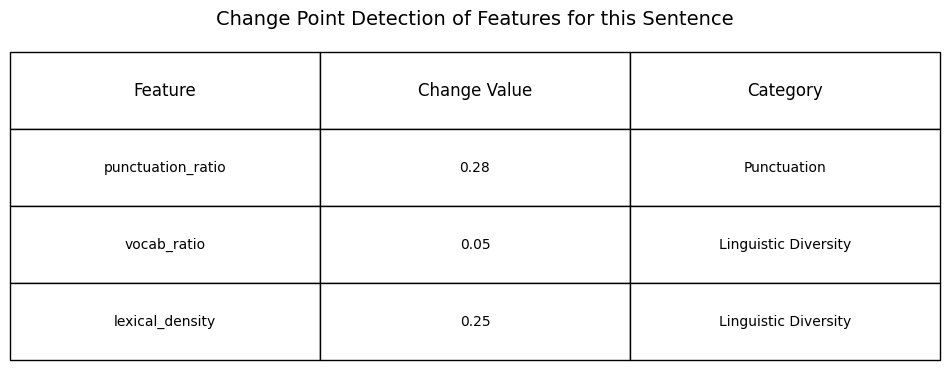


Category Averages for this Explanation:
  Punctuation: 0.2807
  Linguistic Diversity: 0.1535

Overall Average for this Explanation: 0.2171
The text is likely human-written.

Change detected in sentence: The boxing all-time great is a middling politician of mediocre achievement, but he is ‚Äúmasa,‚Äù moneyed, and motivated.
Feature changes:


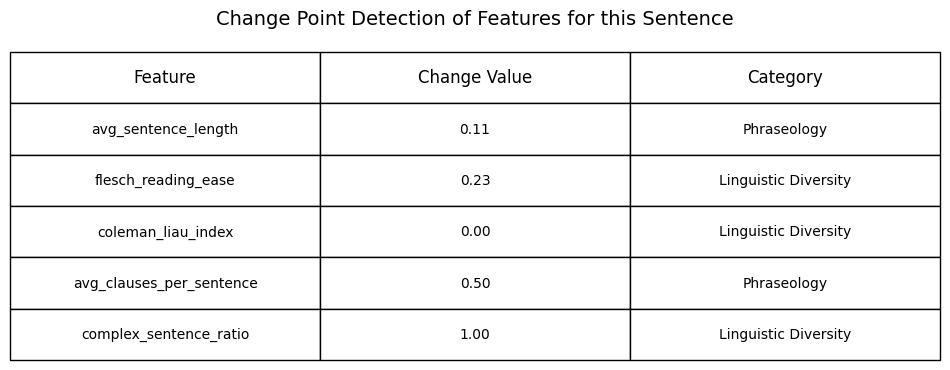


Category Averages for this Explanation:
  Phraseology: 0.3050
  Linguistic Diversity: 0.4089

Overall Average for this Explanation: 0.3570
The text is likely human-written.

Change detected in sentence: But instead of a warm welcome or a protective embrace from the presidential palace, this close ally of President Duterte‚Äôs is taking hits on all sides‚Äîand the hits are coming from the President himself or other close allies.
Feature changes:


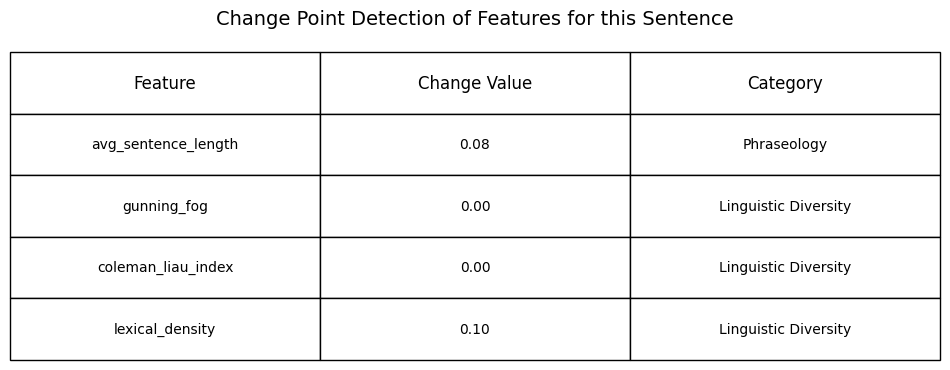


Category Averages for this Explanation:
  Phraseology: 0.0800
  Linguistic Diversity: 0.0327

Overall Average for this Explanation: 0.0564
The text is likely AI-generated.

Change detected in sentence: President Duterte‚Äôs decision to support the unusual and procedurally irregular convening of the PDP-Laban‚Äôs National Council, which took place yesterday in Cebu, over Pacquiao‚Äôs clear objections, was a direct affront to Pacquiao, who is the party president.
Feature changes:


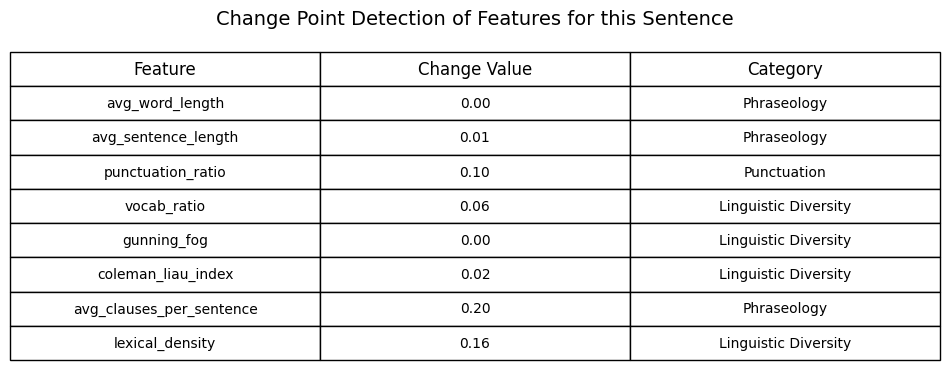


Category Averages for this Explanation:
  Phraseology: 0.0700
  Punctuation: 0.1012
  Linguistic Diversity: 0.0610

Overall Average for this Explanation: 0.0774
The text is likely AI-generated.

Change detected in sentence: (Or at least he is, at the time of writing.
Feature changes:


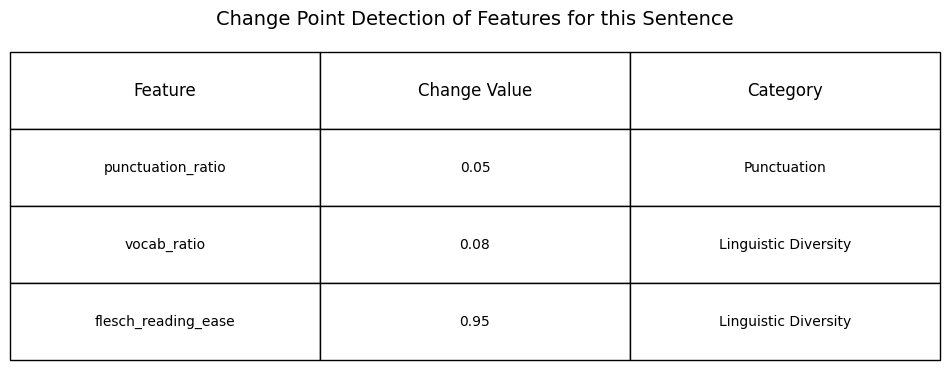


Category Averages for this Explanation:
  Punctuation: 0.0462
  Linguistic Diversity: 0.5152

Overall Average for this Explanation: 0.2807
The text is likely human-written.

Change detected in sentence: It may, in fact, only be a matter of time.)
Feature changes:


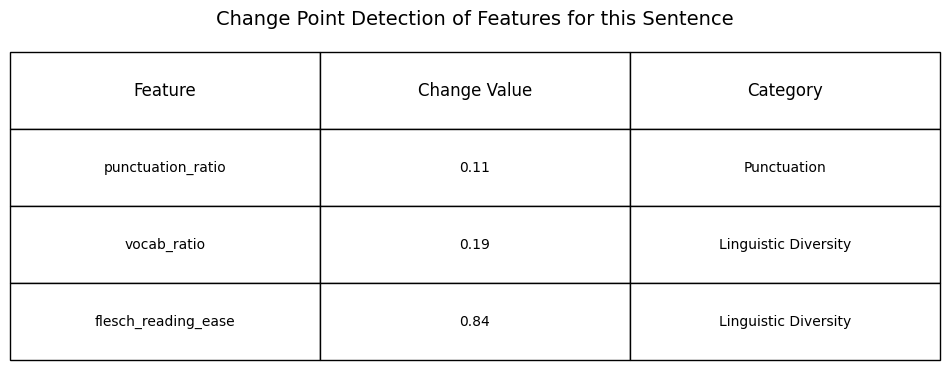


Category Averages for this Explanation:
  Punctuation: 0.1125
  Linguistic Diversity: 0.5116

Overall Average for this Explanation: 0.3121
The text is likely human-written.

Change detected in sentence: It‚Äôs important to note who showed up, whether physically or on Zoom, at the National Council meeting: Speaker Lord Allan Velasco, who is party executive vice president; Senators Francis Tolentino and Bato dela Rosa (who earlier said he would be too busy in the Senate to attend); Executive Secretary Salvador Medialdea and Finance Secretary Carlos Dominguez; congressmen including Ronaldo Zamora and Joey Salceda, and governors including Ben Evardone and Gwen Garcia.
Feature changes:


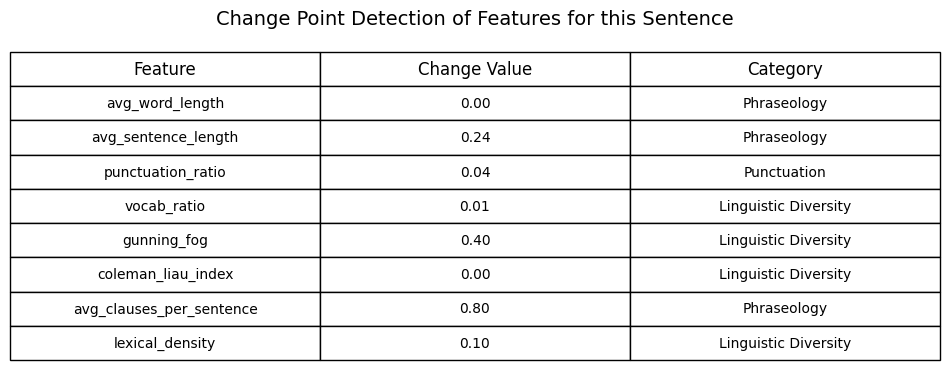


Category Averages for this Explanation:
  Phraseology: 0.3467
  Punctuation: 0.0417
  Linguistic Diversity: 0.1282

Overall Average for this Explanation: 0.1722
The text is likely human-written.

Change detected in sentence: Not exactly a list of party veterans.
Feature changes:


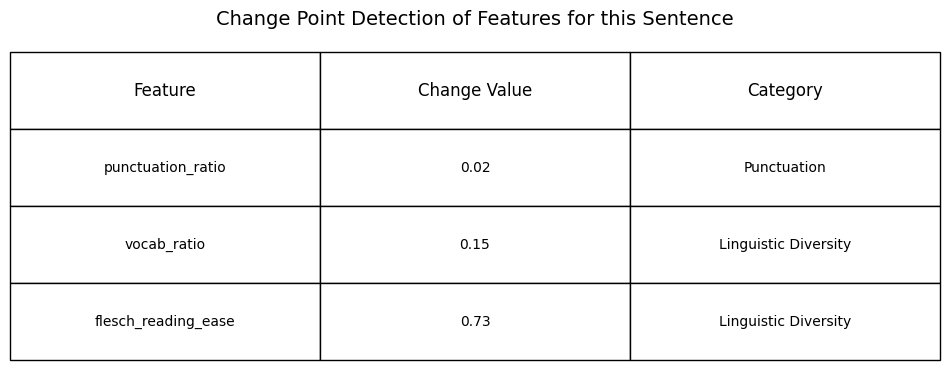


Category Averages for this Explanation:
  Punctuation: 0.0179
  Linguistic Diversity: 0.4435

Overall Average for this Explanation: 0.2307
The text is likely human-written.

Change detected in sentence: I recall that Lito Banayo, the President‚Äôs original political strategist, already predicted the end of Pacquiao‚Äôs party presidency last March; he revealed that the President spoke to Pacquiao on March 3, to ask him to ‚Äúlower his political sights for 2022.‚Äù The heavy-handed manner in which Cusi et al.
Feature changes:


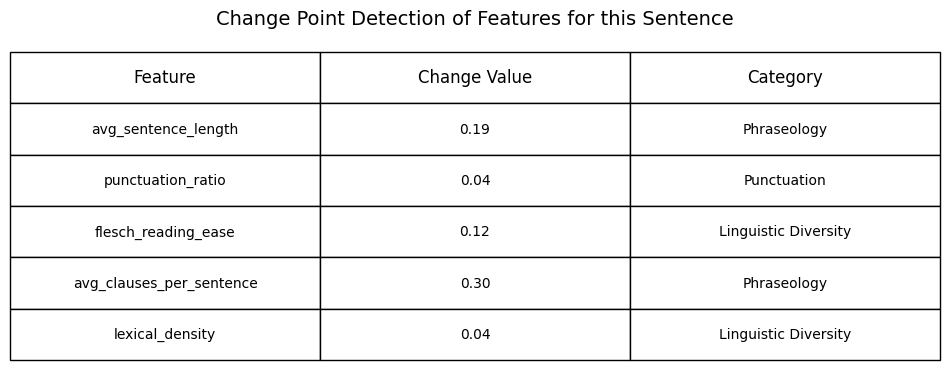


Category Averages for this Explanation:
  Phraseology: 0.2450
  Punctuation: 0.0424
  Linguistic Diversity: 0.0798

Overall Average for this Explanation: 0.1224
The text is likely AI-generated.

Change detected in sentence: reasserted control over PDP-Laban must mean either that Pacquiao refused the President‚Äôs request or that he hasn‚Äôt made up his mind yet.
Feature changes:


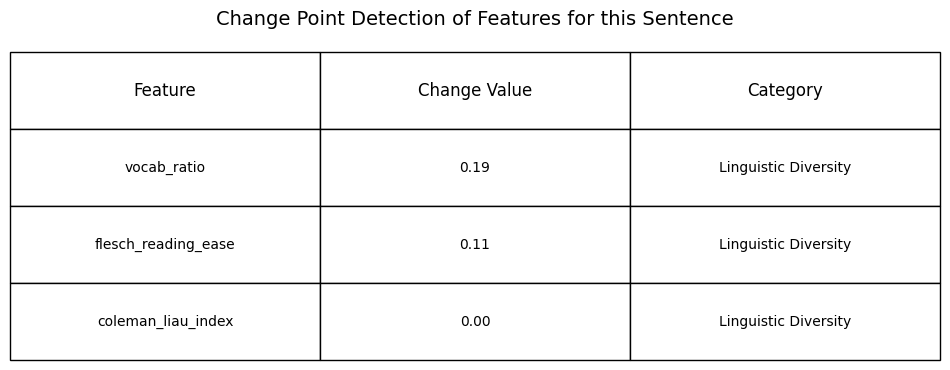


Category Averages for this Explanation:
  Linguistic Diversity: 0.0986

Overall Average for this Explanation: 0.0986
The text is likely AI-generated.

Change detected in sentence: (Here‚Äôs a reminder, however, that we must take the columns of a political operator with a sack of salt; in that same piece, Banayo summed up the directive to Pacquiao as ‚Äúpahinog ka muna sa Senado‚Äù‚Äîliterally, ripen in the Senate‚Äîwhile promoting the idea of a Bong-Go-for-president, Rudy-Duterte-for-vice-president tandem.
Feature changes:


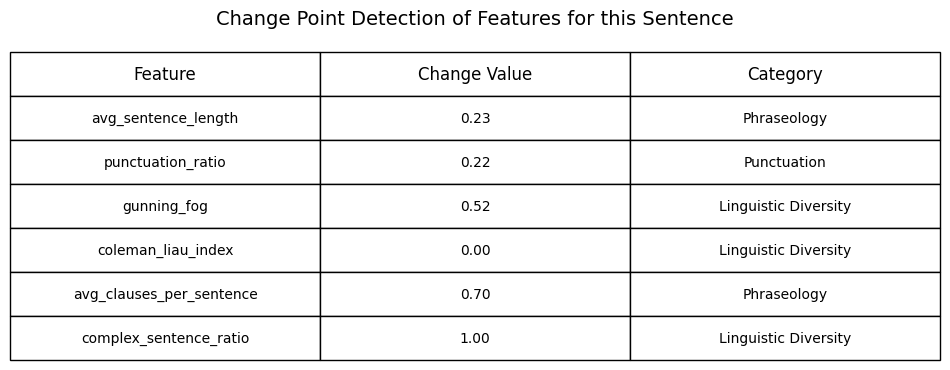


Category Averages for this Explanation:
  Phraseology: 0.4650
  Punctuation: 0.2174
  Linguistic Diversity: 0.5079

Overall Average for this Explanation: 0.3968
The text is likely human-written.

Change detected in sentence: As the election approaches, several challenges have emerged.
Feature changes:


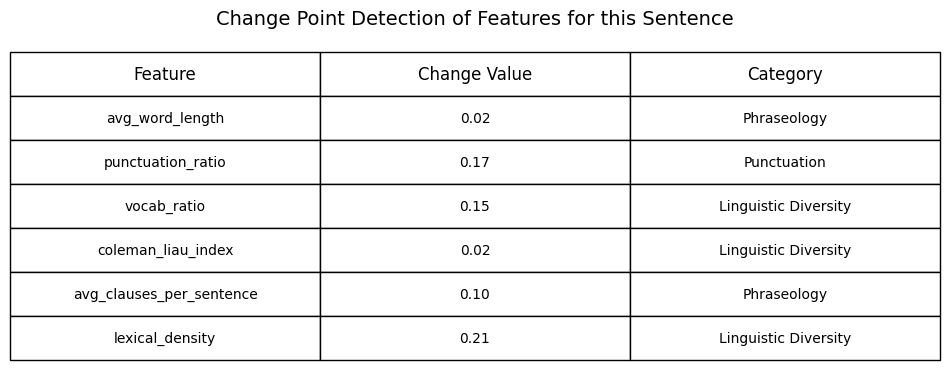


Category Averages for this Explanation:
  Phraseology: 0.0580
  Punctuation: 0.1731
  Linguistic Diversity: 0.1271

Overall Average for this Explanation: 0.1194
The text is likely AI-generated.

Change detected in sentence: Security concerns are paramount, with certain areas being declared as election hotspots due to potential violence.
Feature changes:


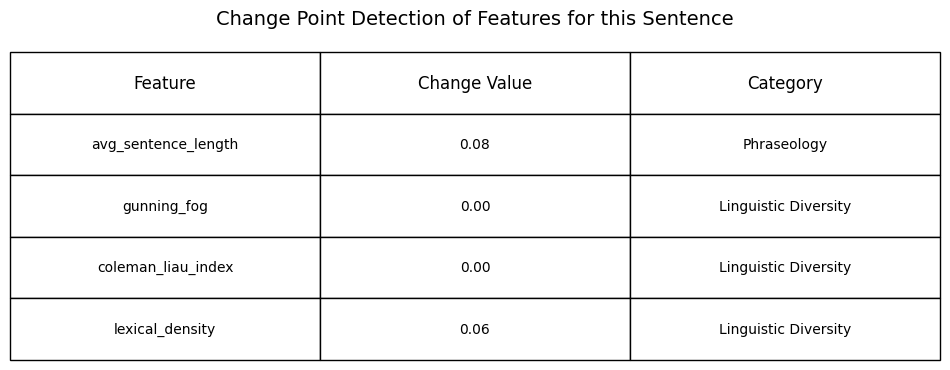


Category Averages for this Explanation:
  Phraseology: 0.0800
  Linguistic Diversity: 0.0208

Overall Average for this Explanation: 0.0504
The text is likely AI-generated.

Change detected in sentence: The Comelec has identified multiple cities and municipalities under red-level alerts, necessitating heightened security measures to ensure a peaceful electoral process.
Feature changes:


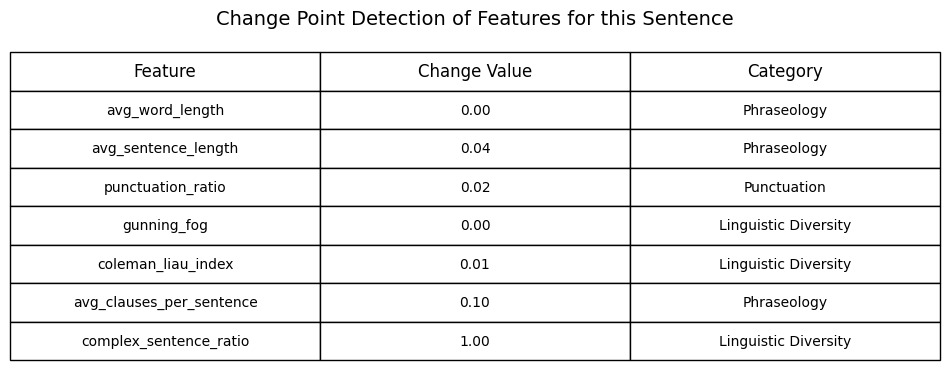


Category Averages for this Explanation:
  Phraseology: 0.0467
  Punctuation: 0.0250
  Linguistic Diversity: 0.3381

Overall Average for this Explanation: 0.1366
The text is likely AI-generated.

Change detected in sentence: But Pacquiao, from all accounts, is a proud man.
Feature changes:


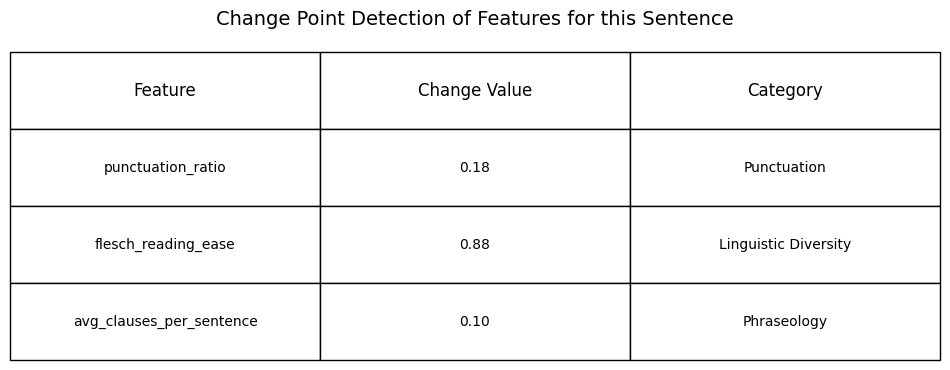


Category Averages for this Explanation:
  Phraseology: 0.1000
  Punctuation: 0.1833
  Linguistic Diversity: 0.8832

Overall Average for this Explanation: 0.3888
The text is likely human-written.

Change detected in sentence: Millions of Filipinos know his background; it is a true rags-to-the-Ritz story.
Feature changes:


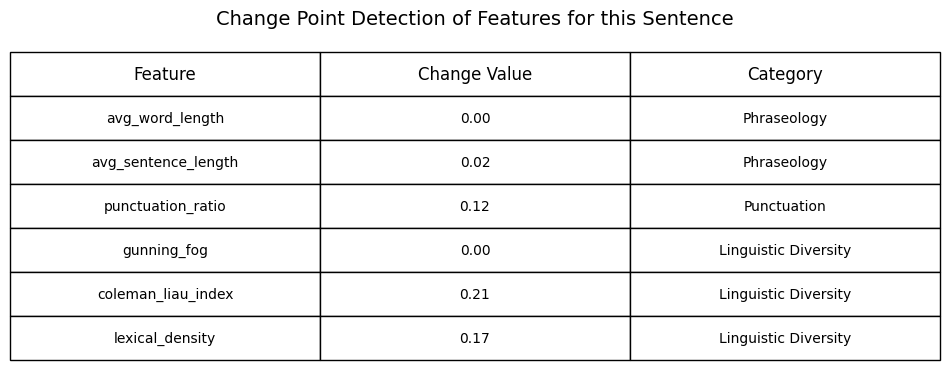


Category Averages for this Explanation:
  Phraseology: 0.0100
  Punctuation: 0.1212
  Linguistic Diversity: 0.1267

Overall Average for this Explanation: 0.0860
The text is likely AI-generated.

Change detected in sentence: The masterminds behind the takeover must have calculated that he will eventually agree to settle for another run at the Senate; it will not do to have him serve as Sara‚Äôs running mate, since they are both from Mindanao.
Feature changes:


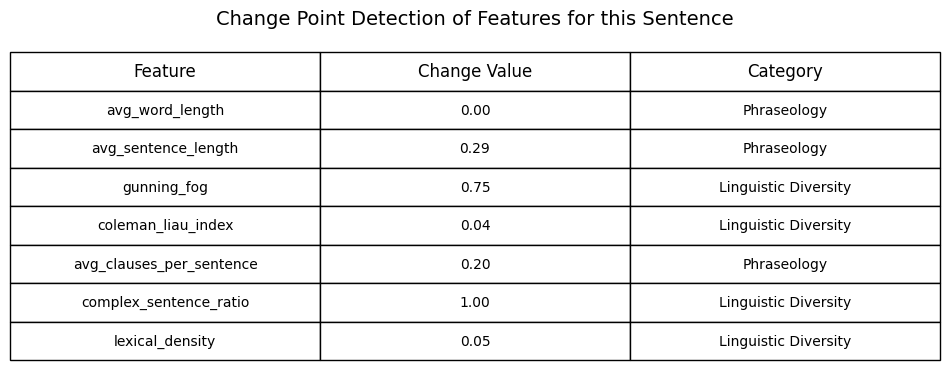


Category Averages for this Explanation:
  Phraseology: 0.1633
  Linguistic Diversity: 0.4585

Overall Average for this Explanation: 0.3109
The text is likely human-written.

Change detected in sentence: Last week, he criticized Sen. Pia Cayetano for disrespecting him on a matter involving a priority legislation of his, and last year he pushed back against Alan Peter Cayetano, then the Speaker, when he defended his proposal to renew the ABS-CBN network‚Äôs congressional franchise.
Feature changes:


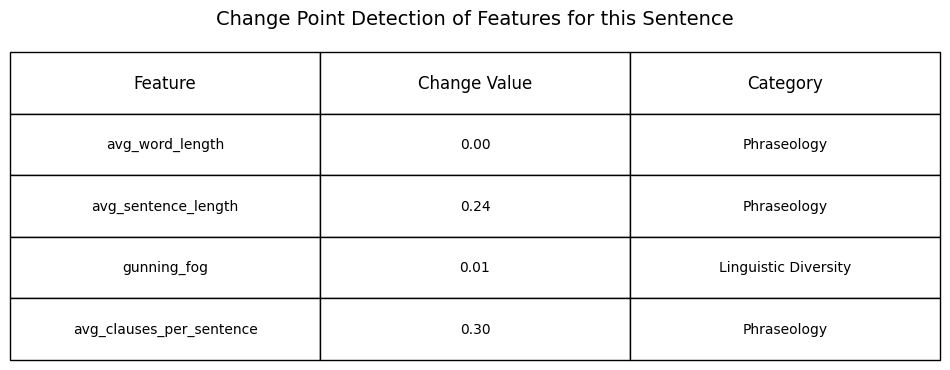


Category Averages for this Explanation:
  Phraseology: 0.1800
  Linguistic Diversity: 0.0064

Overall Average for this Explanation: 0.0932
The text is likely AI-generated.

Change detected in sentence: To be sure, there‚Äôs more to the running feud with the Cayetanos, involving local politics.
Feature changes:


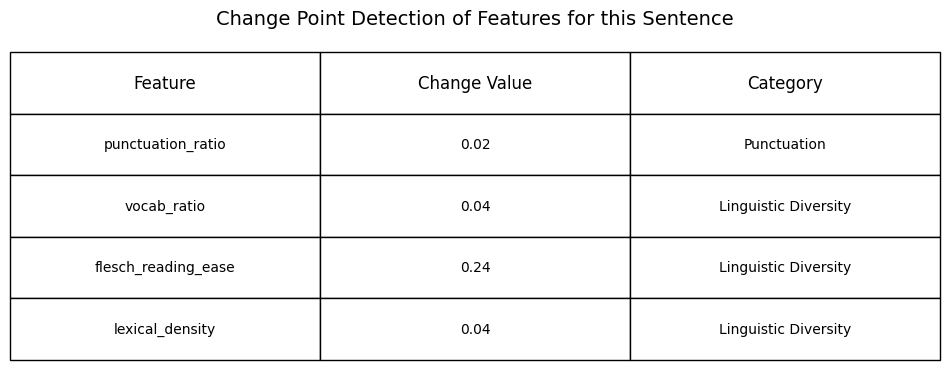


Category Averages for this Explanation:
  Punctuation: 0.0247
  Linguistic Diversity: 0.1048

Overall Average for this Explanation: 0.0647
The text is likely AI-generated.

Change detected in sentence: And yet here we are.
Feature changes:


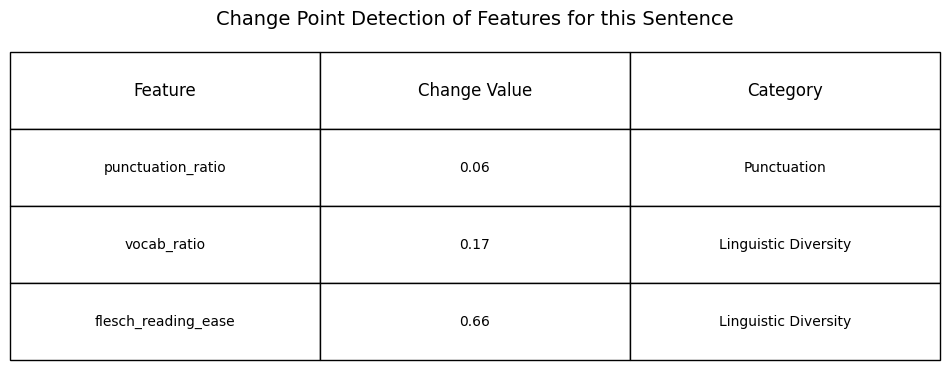


Category Averages for this Explanation:
  Punctuation: 0.0621
  Linguistic Diversity: 0.4144

Overall Average for this Explanation: 0.2382
The text is likely human-written.

Change detected in sentence: A Senate dominated by allies of the current administration could facilitate the passage of key legislative initiatives, while a chamber with a strong opposition could serve as a check on executive power.
Feature changes:


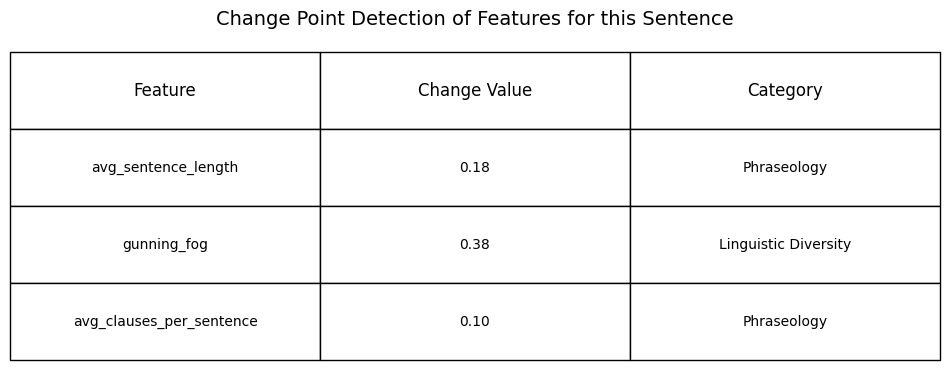


Category Averages for this Explanation:
  Phraseology: 0.1400
  Linguistic Diversity: 0.3773

Overall Average for this Explanation: 0.2586
The text is likely human-written.

Change detected in sentence: The potential entry of influential figures like Pacquiao and members of the Duterte family into the Senate race adds layers of complexity to the political equation.
Feature changes:


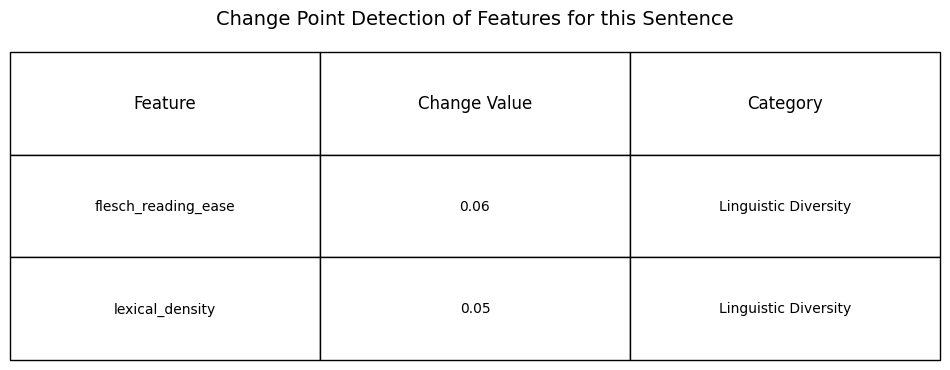


Category Averages for this Explanation:
  Linguistic Diversity: 0.0533

Overall Average for this Explanation: 0.0533
The text is likely AI-generated.

Change detected in sentence: Voters will be tasked with discerning the candidates' platforms, track records, and visions for the country's future.
Feature changes:


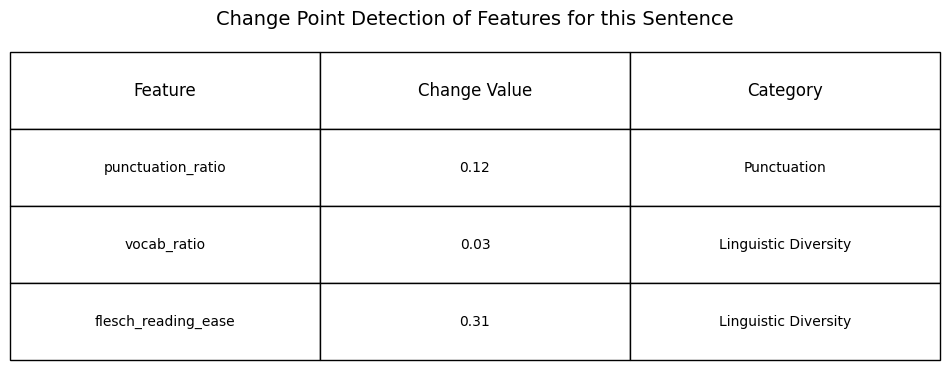


Category Averages for this Explanation:
  Punctuation: 0.1202
  Linguistic Diversity: 0.1714

Overall Average for this Explanation: 0.1458
The text is likely AI-generated.
Human Sentence Count:  13
AI Sentence Count:  15

Changepoint Detection DataFrame:


Sentence Index                                           Sentence              Feature  Change Value              Category
0                 3  Central to the 2025 elections is the escalatin...      avg_word_length      0.000000           Phraseology
1                 3  Central to the 2025 elections is the escalatin...   coleman_liau_index      0.000000  Linguistic Diversity
2                 4  Once allies, their relationship has deteriorat...      avg_word_length      0.000000           Phraseology
3                 4  Once allies, their relationship has deteriorat...    punctuation_ratio      0.292208           Punctuation
4                 4  Once allies, their relationship has deteriorat...          vocab_ratio      0.142857  Linguistic Diversity
..              ...                                                ...                  ...           ...                   ...
123              48  The potential entry of influential figures lik...  flesch_reading_ease      0.060900  Linguistic Diversity
124              48  The potential entry of influential figures lik...      lexical_density      0.045673  Linguistic Diversity
125              50  Voters will be tasked with discerning the cand...    punctuation_ratio      0.120205           Punctuation
126              50  Voters will be tasked with discerning the cand...          vocab_ratio      0.028133  Linguistic Diversity
127              50  Voters will be tasked with discerning the cand...  flesch_reading_ease      0.314700  Linguistic Diversity

[128 rows x 5 columns]

In [17]:
new_text = """As the Philippines approaches its midterm elections on May 12, 2025, the political landscape is marked by intense rivalries, shifting alliances, and significant implications for the nation's future. This electoral event will not only serve as a referendum on President Ferdinand "Bongbong" Marcos Jr.'s administration but also redefine the power dynamics among the country's prominent political families and parties.

With all the maneuvering for next year‚Äôs elections, the cracks in the Duterte governing coalition are widening.
Central to the 2025 elections is the escalating tension between the Marcos and Duterte dynasties. Once allies, their relationship has deteriorated, leading to a high-stakes political contest. Former President Rodrigo Duterte, at 79, has announced his candidacy for mayor of Davao City, a position he previously held for over two decades. This move is seen as an attempt to reassert his family's influence and challenge President Marcos Jr.'s leadership. The Duterte family's political resurgence is further underscored by the candidacies of Duterte's sons, with speculation that they might seek Senate seats to counterbalance Marcos's authority. This development follows the collapse of their previous alliance, which was crucial for Marcos's 2022 victory, due to policy differences and scandals

Manny Pacquiao, renowned globally for his boxing prowess, has also carved a notable path in Philippine politics. After serving as a senator from 2016 to 2022 and mounting a presidential campaign in 2022, Pacquiao has remained an active political figure. In May 2024, he announced his candidacy for the Senate under the banner of the Alyansa para sa Bagong Pilipinas (Alliance for the New Philippines), a coalition formed by major political parties, including the Partido Federal ng Pilipinas (PFP) and Lakas-CMD. This coalition aims to consolidate support for the current administration and presents a formidable force in the upcoming elections.

Consider the situation of Sen. Manny Pacquiao. The boxing all-time great is a middling politician of mediocre achievement, but he is ‚Äúmasa,‚Äù moneyed, and motivated. The 2022 elections will be the first presidential poll where he will be old enough to run for president himself. If he wins his fight against world welterweight champion Errol Spence in August, add both massive media mileage and momentum to his set of advantages as a candidate in May. But instead of a warm welcome or a protective embrace from the presidential palace, this close ally of President Duterte‚Äôs is taking hits on all sides‚Äîand the hits are coming from the President himself or other close allies.

President Duterte‚Äôs decision to support the unusual and procedurally irregular convening of the PDP-Laban‚Äôs National Council, which took place yesterday in Cebu, over Pacquiao‚Äôs clear objections, was a direct affront to Pacquiao, who is the party president. (Or at least he is, at the time of writing. Having swiftly replaced the party secretary-general by presuming that seat vacant, the members of the National Council under the leadership of party vice-chair Alfonso Cusi, the energy secretary, can just as easily depose Pacquiao. It may, in fact, only be a matter of time.)

The reason for the internal coup of the official administration party on record is apparent: Davao City Mayor Inday Sara Duterte is running for president next year, in a bid to succeed her father and to protect him from legal complications, and she needs a national political party.
It‚Äôs important to note who showed up, whether physically or on Zoom, at the National Council meeting: Speaker Lord Allan Velasco, who is party executive vice president; Senators Francis Tolentino and Bato dela Rosa (who earlier said he would be too busy in the Senate to attend); Executive Secretary Salvador Medialdea and Finance Secretary Carlos Dominguez; congressmen including Ronaldo Zamora and Joey Salceda, and governors including Ben Evardone and Gwen Garcia. Not exactly a list of party veterans. Rather, this is a large chunk of the governing coalition who are interested in continuity, violating the party‚Äôs own rules to effectively remove Pacquiao from any real power.

I recall that Lito Banayo, the President‚Äôs original political strategist, already predicted the end of Pacquiao‚Äôs party presidency last March; he revealed that the President spoke to Pacquiao on March 3, to ask him to ‚Äúlower his political sights for 2022.‚Äù The heavy-handed manner in which Cusi et al. reasserted control over PDP-Laban must mean either that Pacquiao refused the President‚Äôs request or that he hasn‚Äôt made up his mind yet. (Here‚Äôs a reminder, however, that we must take the columns of a political operator with a sack of salt; in that same piece, Banayo summed up the directive to Pacquiao as ‚Äúpahinog ka muna sa Senado‚Äù‚Äîliterally, ripen in the Senate‚Äîwhile promoting the idea of a Bong-Go-for-president, Rudy-Duterte-for-vice-president tandem. But Go was elected to the Senate in 2019, three years after Pacquiao. If Go is ripe for the presidency, after only two years in the Senate, why not Pacquiao? The definition of ripeness here must depend on the tree of political opportunism.)

As the election approaches, several challenges have emerged. Security concerns are paramount, with certain areas being declared as election hotspots due to potential violence. The Comelec has identified multiple cities and municipalities under red-level alerts, necessitating heightened security measures to ensure a peaceful electoral process.

But Pacquiao, from all accounts, is a proud man. Millions of Filipinos know his background; it is a true rags-to-the-Ritz story. This takeover of his party will not sit well with him. The masterminds behind the takeover must have calculated that he will eventually agree to settle for another run at the Senate; it will not do to have him serve as Sara‚Äôs running mate, since they are both from Mindanao. But at 42, Pacquiao cannot depend on many more fights, to reinforce his appealing narrative to the masses and to raise more money for his political campaigns. The 2022 presidential election would likely be his best chance at becoming president; he can certainly cut into Sara‚Äôs Mindanao base, and hold his own against Bongbong Marcos and Isko Moreno in Luzon. The Cusi takeover must assume that the lack of a national political party to support his candidacy will be fatal to Pacquiao‚Äôs chances; recent history is much more ambiguous.

Although outmatched in the Senate, in terms of debating skill or alliance-building, Pacquiao has started to become much more assertive. Last week, he criticized Sen. Pia Cayetano for disrespecting him on a matter involving a priority legislation of his, and last year he pushed back against Alan Peter Cayetano, then the Speaker, when he defended his proposal to renew the ABS-CBN network‚Äôs congressional franchise. To be sure, there‚Äôs more to the running feud with the Cayetanos, involving local politics. And the Cayetanos are not fond of a Sara candidacy; attacking Pacquiao, a clear rival to Sara, is not in the Cayetano family‚Äôs interest on the national level. And yet here we are.

The outcome of the 2025 midterm elections will have far-reaching implications for the Philippines' political future. A Senate dominated by allies of the current administration could facilitate the passage of key legislative initiatives, while a chamber with a strong opposition could serve as a check on executive power. The potential entry of influential figures like Pacquiao and members of the Duterte family into the Senate race adds layers of complexity to the political equation. As the nation moves closer to election day, the interplay of established political dynasties, emerging coalitions, and independent voices will shape the discourse. Voters will be tasked with discerning the candidates' platforms, track records, and visions for the country's future. In this dynamic environment, Manny Pacquiao's unique blend of celebrity and political experience positions him as a focal point in the unfolding narrative of the Philippines' democratic journey."""
author = "John Nery"

# Detect changepoints, explanations, and changepoint DataFrame
changepoints, explanations, changepoint_df, newText_featuresdf, average_value, pred_author = detect_change_points_in_text(new_text, author, clf)

# Display options for pandas to prevent compression issues
pd.set_option('display.max_rows', 20)  # Show up to 20 rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust column width

# Display the changepoint DataFrame
print("\nChangepoint Detection DataFrame:")
display(changepoint_df)

In [18]:
# Check if the author exists in the DataFrame and has ai_label = 0
if ((df_normalized_features['author'] == author) & (df_normalized_features['ai_label'] == 0)).any():
    print(f"Author '{author}'\n")
    
    # Create copies of the DataFrames
    changepoint_ave = average_value.copy()
    predicted_auth = pred_author.copy()
    author_featuredf = df_normalized_features.copy()
    normalized_newText_featuresdf = newText_featuresdf.copy()
    
    # Normalize the required columns for the inputted text
    for col in newText_featuresdf.columns:
        if col in feature_ranges:  # Only normalize columns that exist in feature_ranges
            normalized_newText_featuresdf[f"{col}_normalized"] = newText_featuresdf[col].apply(
                lambda x: normalize_feature(x, col, feature_ranges)
            )
    
    # Keep only the normalized columns
    normalized_newText_featuresdf = normalized_newText_featuresdf[
        [f"{col}_normalized" for col in feature_ranges if col in newText_featuresdf.columns]
    ]

    # Define feature groups
    feature_groups = {
        'Phraseology': ['word_count_normalized', 'avg_word_length_normalized', 
                        'avg_sentence_length_normalized', 'avg_clauses_per_sentence_normalized'],
        'Punctuation': ['punctuation_ratio_normalized', 'avg_punctuation_per_sentence_normalized'],
        'Linguistic Diversity': ['vocab_size_normalized', 'vocab_ratio_normalized', 'lexical_density_normalized', 
                                  'flesch_reading_ease_normalized', 'gunning_fog_normalized', 
                                  'smog_index_normalized', 'coleman_liau_index_normalized', 
                                  'complex_sentence_ratio_normalized']
    }

    # Compute averages for each feature group in newText_featuresdf
    for new_col, cols_to_average in feature_groups.items():
        valid_cols = [col for col in cols_to_average if col in normalized_newText_featuresdf.columns]
        
        if valid_cols:  # Only proceed if there are valid columns to compute
            normalized_newText_featuresdf[new_col] = normalized_newText_featuresdf[valid_cols].mean(axis=1)
            
            # Drop the original columns after calculation
            normalized_newText_featuresdf.drop(valid_cols, axis=1, inplace=True)
    
    # Calculate the overall average across the 3 categories for newText_featuresdf
    category_cols = list(feature_groups.keys())  # ['Phraseology', 'Punctuation', 'Linguistic Diversity']
    normalized_newText_featuresdf["Overall_Average"] = normalized_newText_featuresdf[category_cols].mean(axis=1)
    
    # Apply the same calculations to author_featuredf
    author_featuredf = author_featuredf[author_featuredf['author'] == author]  # Filter for the specific author
    author_featuredf = author_featuredf[author_featuredf['ai_label'] == 0]  # Keep only rows where ai_label = 0

    # Compute averages for each feature group across all rows (row-wise mean)
    author_aggregated = {}  # Dictionary to store category-wise averages
    
    for new_col, cols_to_average in feature_groups.items():
        valid_cols = [col for col in cols_to_average if col in author_featuredf.columns]
        
        if valid_cols:  # Only proceed if there are valid columns to compute
            author_aggregated[new_col] = author_featuredf[valid_cols].mean().mean()  # Get row-wise mean, then overall mean

    # Convert dictionary to DataFrame
    author_featuredf = pd.DataFrame([author_aggregated])

    # Calculate the overall average across the 3 categories
    author_featuredf["Overall_Average"] = author_featuredf.mean(axis=1)

    # Extract overall averages
    overall_avg_new_text = normalized_newText_featuresdf["Overall_Average"].values[0]  # Single value
    overall_avg_author = author_featuredf["Overall_Average"].values[0]  # Single value

    # Calculate similarity percentage
    similarity_percentage = 100 - (abs(overall_avg_new_text - overall_avg_author) / max(overall_avg_new_text, overall_avg_author) * 100)

    # Display the results
    print("Inputted Text Features:\n", normalized_newText_featuresdf.head())
    print("\nAuthor's Features:\n", author_featuredf)
    #print(f"\nüîπ Percentage Similarity: {similarity_percentage:.2f}% üîπ")
    print("\n")
    if changepoint_ave > 0.15:
        print(f"The text is likely human-written. The Predicted author is {predicted_auth} with a confidence of {similarity_percentage:.2f}%")
    elif changepoint_ave <= 0.15:
        print(f"The text is likely AI-Generated. The Predicted author is {predicted_auth} with a confidence of {similarity_percentage:.2f}%")
    else:
        print("No change points detected; no averages to calculate.")

else:
    normalized_newText_featuresdf = None
    author_featuredf = None

Author 'John Nery'

Inputted Text Features:
    Phraseology  Punctuation  Linguistic Diversity  Overall_Average
0     0.270387     0.253009              0.617416         0.380271

Author's Features:
    Phraseology  Punctuation  Linguistic Diversity  Overall_Average
0     0.265578     0.238282              0.569111         0.357657


The text is likely human-written. The Predicted author is ['Diwa C. Guinigundo'] with a confidence of 94.05%


In [19]:
def detect_change_points_in_csv(new_text, author, trained_model):
    # Preprocess and extract features for the new text
    features = extract_features(preprocess_text(new_text))
    
    features_df = pd.DataFrame([features])
    features_df = features_df[['word_count', 'avg_word_length', 'avg_sentence_length',
        'punctuation_ratio', 'avg_punctuation_per_sentence', 'vocab_size', 'vocab_ratio', 
        'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
        'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']]
    
    predicted_author = trained_model.predict(features_df)

    # print(f"Provided Author: {author}")
    # print(f"Predicted Author: {predicted_author}")
    
    # if predicted_author[0] != author:
    #     print(f"Warning: The provided author does not match the predicted author. Using provided author '{author}' for analysis. Predicted author is: '{predicted_author}'")
    
    # Extract stylometric features for each sentence
    sentences = sent_tokenize(new_text)
    sentence_features = []
    
    for sentence in sentences:
        preprocessed_sentence = preprocess_text(sentence)
        sentence_feature = extract_features(preprocessed_sentence)
        
        selected_features = [
            sentence_feature['avg_word_length'], 
            sentence_feature['avg_sentence_length'], 
            sentence_feature['punctuation_ratio'], 
            sentence_feature['vocab_ratio'],
            sentence_feature['flesch_reading_ease'],
            sentence_feature['gunning_fog'],
            sentence_feature['smog_index'],
            sentence_feature['coleman_liau_index'],
            sentence_feature['avg_clauses_per_sentence'],
            sentence_feature['complex_sentence_ratio'],
            sentence_feature['lexical_density']
        ]
        sentence_features.append(selected_features)
    
    sentence_features = np.array(sentence_features)
    
    # Initialize BOCPD model for multivariate data
    hazard_func = lambda t: constant_hazard(250, t)
    initial_mean = np.mean(sentence_features, axis=0)
    initial_covariance = np.cov(sentence_features, rowvar=False)  # Initial covariance matrix
    
    predictive_model = MultivariateGaussianPredictiveModel(mu0=initial_mean, beta0=initial_covariance)
    
    # Run BOCPD on all selected features (multivariate analysis)
    P, max_run_length = bocpd(sentence_features, hazard_func, predictive_model)

    # Detect change points
    changepoints = detect_change_points(max_run_length)
    
    feature_categories = {
        'Phraseology': ['avg_word_length', 'avg_sentence_length', 'avg_clauses_per_sentence'],
        'Punctuation': ['punctuation_ratio'],
        'Linguistic Diversity': ['vocab_ratio', 'lexical_density', 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index', 'complex_sentence_ratio'],
    }
    
    explanations = []
    changepoint_data = []  # List to collect data for DataFrame
    
    # Initialize counters for category changes
    category_changes = {category: set() for category in feature_categories.keys()}
    
    for idx in changepoints:
        if idx > 0 and idx < len(sentences):
            prev_features = sentence_features[idx - 1]
            curr_features = sentence_features[idx]
            
            feature_changes = []
            category_change_sums = {category: [] for category in feature_categories.keys()}  # Collect values for averaging
            
            for i, feature_name in enumerate(
                ['avg_word_length', 'avg_sentence_length', 'punctuation_ratio', 'vocab_ratio',
                 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
                 'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']):
                
                change = curr_features[i] - prev_features[i]
                
                if change > 0:  # Process only positive changes
                    category = next((cat for cat, features in feature_categories.items() if feature_name in features), None)
    
                    if category:
                        category_changes[category].add(idx)
    
                        # Normalize change and ensure non-negative value
                        normalized_change = max(normalize_feature(change, feature_name, feature_ranges), 0)
    
                        feature_changes.append({
                            'Feature': feature_name,
                            'Change Value': normalized_change,
                            'Category': category
                        })
                        
                        category_change_sums[category].append(normalized_change)  # Store change values for averaging
                        
                        # Add row to changepoint data
                        changepoint_data.append({
                            'Sentence Index': idx,
                            'Sentence': sentences[idx],
                            'Feature': feature_name,
                            'Change Value': normalized_change,
                            'Category': category
                        })
        
            if feature_changes:  # Only add explanations if there are valid positive changes
                explanation = {
                    'sentence': sentences[idx],
                    'feature_changes': feature_changes
                }
                
                # Calculate category-wise averages for this specific explanation
                category_averages = {}
                for category, values in category_change_sums.items():
                    if values:  # Ensure there are values before averaging
                        category_averages[category] = sum(values) / len(values)
    
                explanation['category_averages'] = category_averages  # Store averages
                
                # Compute the overall average for this explanation
                if category_averages:
                    overall_explanation_avg = sum(category_averages.values()) / len(category_averages)
                    explanation['overall_explanation_avg'] = overall_explanation_avg  # Store it in the explanation
                    
                explanations.append(explanation)

    # Create DataFrame from collected changepoint data
    changepoint_df = pd.DataFrame(changepoint_data)
    if not changepoint_df.empty:  # Check if the DataFrame is non-empty
        average_changes = (
            changepoint_df.groupby('Category')['Change Value']
            .mean()
            .reset_index()
            .rename(columns={'Change Value': 'Average Change Value'})
        )
        
        # print("\n--- Average Normalized Change Value by Category ---")
        # print(average_changes)
    else:
        print("No change points detected; no averages to calculate.") 

    # Summarize the average changes across all categories
    overall_mean = average_changes['Average Change Value'].sum() / 3  # Divide the sum by 3 categories

    return changepoints, explanations, changepoint_df, features_df, overall_mean, predicted_author


In [20]:
df = pd.read_csv("new_dataset_testv2.csv")

# List of AI models
ai_models = ["Phind Instant", "GPT4o-mini", "Llama3.2", "Gemini1.5-flash", "Copilot"]

# Create a new list to store results
results = []

# Iterate over each row in the dataframe
for index, row in df.iterrows():
    author = row["author"]
    new_text = row["new_text"]
    ai_label = row["ai_label"]  # Include ai_label

    # Call the function with the extracted parameters
    changepoints, explanations, changepoint_df, features_df, overall_mean, predicted_author = detect_change_points_in_csv(new_text, author, clf)

    # Store the results
    results.append({
        "author": author,
        "new_text": new_text,
        "ai_label": ai_label,  # Store ai_label in results
        "overall_mean": overall_mean,
        "predicted_author": predicted_author[0],
        "if_pred_author_correct": int(author == predicted_author[0]),  # 1 if correct, 0 if incorrect
        "if_pred_author_is_ai": int(predicted_author[0] in ai_models),  # Updated AI author check
        #"predicted_label_025": int(overall_mean > 0.25),  # 1 if > 0.10 (AI), 0 if <= 0.10 (Human)
        "predicted_label_015": int(overall_mean > 0.15),  # 1 if > 0.15 (AI), 0 if <= 0.15 (Human)
        "predicted_label_020": int(overall_mean > 0.20),  # 1 if > 0.20 (AI), 0 if <= 0.20 (Human)
        "predicted_label_015_inv": int(overall_mean < 0.15),  # 1 if < 0.15 (AI), 0 if >= 0.15 (Human)
        "predicted_label_020_inv": int(overall_mean < 0.20),  # 1 if < 0.20 (AI), 0 if >= 0.20 (Human)
        #"predicted_label_025_inv": int(overall_mean <= 0.25)  # 1 if <= 0.10 (Human), 0 if > 0.10 (AI)
    })

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Display the first few rows
results_df

author                                           new_text  ai_label  overall_mean    predicted_author  if_pred_author_correct  if_pred_author_is_ai  predicted_label_015  predicted_label_020  predicted_label_015_inv  predicted_label_020_inv
0   John Nery  The answers she gave in two Senate hearings we...         0      0.234421           John Nery                       1                     0                    1                    1                        0                        0
1   John Nery  Confusing one with the other allows disinforma...         0      0.161875      Maria A. Ressa                       0                     0                    1                    0                        0                        1
2   John Nery  The complicated but lasting legacy of Benedict...         0      0.214882           John Nery                       1                     0                    1                    1                        0                        0
3   John Nery  Now that she has passed the point of no return...         0      0.189058           John Nery                       1                     0                    1                    0                        0                        1
4   John Nery  The communist insurgency is at its weakest. Co...         0      0.186880  Diwa C. Guinigundo                       0                     0                    1                    0                        0                        1
..        ...                                                ...       ...           ...                 ...                     ...                   ...                  ...                  ...                      ...                      ...
95    Copilot  The Stark Realities of Income Inequality in th...         1      0.155589             Copilot                       1                     1                    1                    0                        0                        1
96    Copilot  The Pillars of Progress: Overseas Filipino Wor...         1      0.125543          GPT4o-mini                       0                     1                    0                    0                        1                        1
97    Copilot  A Critical Examination of the Philippines' Foo...         1      0.122534          GPT4o-mini                       0                     1                    0                    0                        1                        1
98    Copilot  Bridging the Digital Divide: Accessibility of ...         1      0.141020          GPT4o-mini                       0                     1                    0                    0                        1                        1
99    Copilot  The Power of Youth: Shaping the Future of Phil...         1      0.115261             Copilot                       1                     1                    0                    0                        1                        1

[100 rows x 11 columns]

In [21]:
# Filter the DataFrame to include only rows where 'ai_label' is 0
author_features_comparisondf = df_normalized_features.copy()

# Maintain the original order of 'author' as they appear in the DataFrame
author_features_comparisondf['author'] = pd.Categorical(
    author_features_comparisondf['author'], 
    categories=df_normalized_features['author'].unique(), 
    ordered=True
)

# Group by 'author' while preserving order
author_aggregated_list = []

for author, author_df in author_features_comparisondf.groupby('author', observed=True):  
    author_aggregated = {'author': author}  # Store author name
    
    for category, features in feature_groups.items():
        valid_features = [col for col in features if col in author_df.columns]
        
        if valid_features:  # Ensure valid columns before calculating
            author_aggregated[category] = author_df[valid_features].mean().mean()
    
    # Calculate overall average across all 3 categories
    author_aggregated["Overall_Average"] = np.mean([author_aggregated[cat] for cat in feature_groups.keys()])
    
    author_aggregated_list.append(author_aggregated)

# Convert list of dictionaries into a DataFrame
author_features_comparisondf = pd.DataFrame(author_aggregated_list)

# Ensure the order remains the same as the original DataFrame
author_features_comparisondf['author'] = pd.Categorical(
    author_features_comparisondf['author'], 
    categories=df_normalized_features['author'].unique(), 
    ordered=True
)

# Sort the DataFrame based on the preserved order
author_features_comparisondf = author_features_comparisondf.sort_values('author')

author_features_comparisondf

author  Phraseology  Punctuation  Linguistic Diversity  Overall_Average
0            John Nery     0.265578     0.238282              0.569111         0.357657
1        Iris Gonzales     0.239468     0.206994              0.529395         0.325286
2       Maria A. Ressa     0.233753     0.201047              0.525232         0.320011
3   Diwa C. Guinigundo     0.247724     0.187103              0.566993         0.333940
4  Jose Ma Montelibano     0.229304     0.182408              0.539352         0.317021
5        Phind Instant     0.302012     0.237264              0.760961         0.433413
6           GPT4o-mini     0.271126     0.202327              0.662314         0.378589
7             Llama3.2     0.257692     0.234857              0.623652         0.372067
8      Gemini1.5-flash     0.262992     0.214499              0.618448         0.365313
9              Copilot     0.270603     0.206408              0.634767         0.370593

<Figure size 500x600 with 0 Axes>

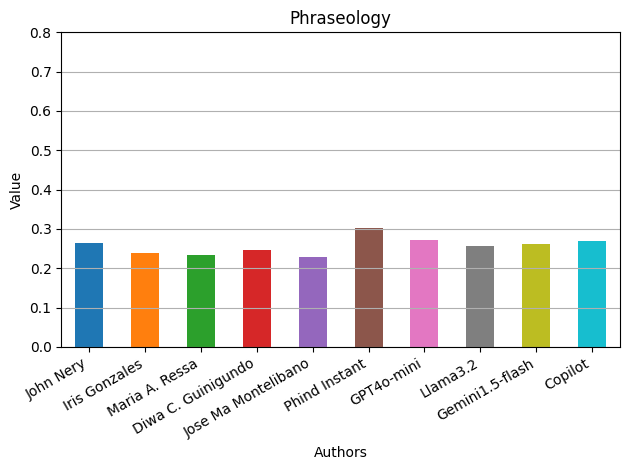

<Figure size 500x600 with 0 Axes>

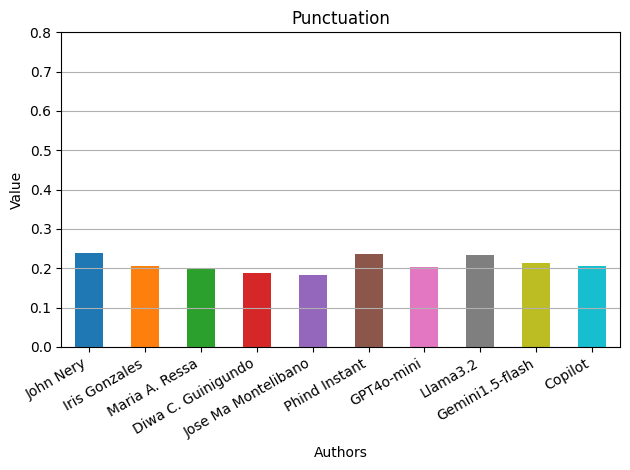

<Figure size 500x600 with 0 Axes>

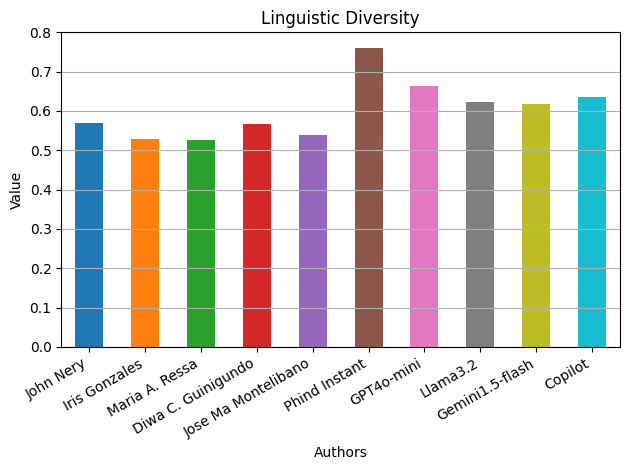

<Figure size 500x600 with 0 Axes>

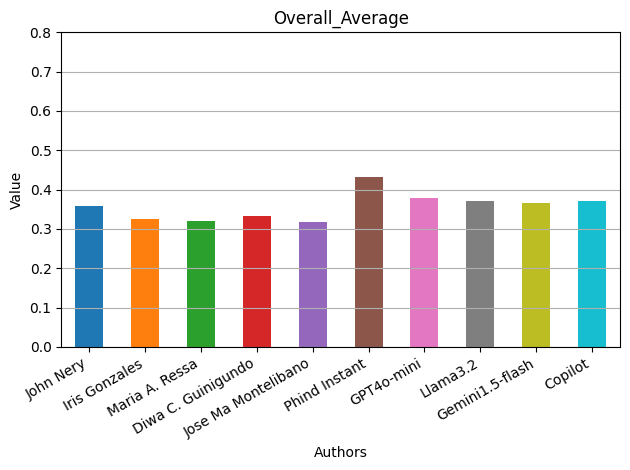

In [22]:
categories = ['Phraseology', 'Punctuation', 'Linguistic Diversity', 'Overall_Average']
unique_authors = author_features_comparisondf["author"].unique()
author_colors = sns.color_palette("tab10", len(unique_authors))  # Use Seaborn's tab10 palette

# Create a color mapping for each author
author_color_map = {author: color for author, color in zip(unique_authors, author_colors)}

# Find global min and max Y values for consistent scaling
y_min = author_features_comparisondf[categories].min().min()
y_max = author_features_comparisondf[categories].max().max()

# Generate separate visualizations for each category
for category in categories:
    plt.figure(figsize=(5,6))  # Set individual graph size while keeping the same overall ratio
    
    # Get colors for each author in the same order as the DataFrame
    colors = [author_color_map[author] for author in author_features_comparisondf["author"]]
    
    # Plot bar chart
    author_features_comparisondf.plot(
        x='author', y=category, kind='bar', stacked=True, legend=False, color=colors
    )
    
    plt.title(category)
    plt.xlabel("Authors")
    plt.ylabel("Value")
    plt.ylim(y_min, y_max)  # Keep Y-axis scale consistent across all graphs

    # Ensure Y-axis labels include 0.1 intervals
    y_ticks = np.arange(0, y_max + 0.1, 0.1)  # Generate ticks at 0.1 intervals
    plt.yticks(y_ticks)

    plt.xticks(rotation=30, ha="right", fontsize=10)  # Rotate X labels for readability
    plt.grid(axis='y', linestyle='-', alpha=1)
    
    plt.tight_layout()  
    plt.show()

In [23]:
# df_results = pd.read_csv('main_dataset_test.csv')
# df_results

In [24]:
# # df_results

# Access columns from the DataFrame
ai_label = results_df['ai_label']
predicted_label_015_inv = results_df['predicted_label_015_inv']
predicted_label_020 = results_df['predicted_label_020']
predicted_label_015 = results_df['predicted_label_015']
predicted_label_020_inv = results_df['predicted_label_020_inv']

# #Model Evaluation
accuracy015inv = accuracy_score(ai_label, predicted_label_015_inv) 
print("\nAccuracy Threshold 0.15 Inverse:", accuracy015inv)
accuracy015 = accuracy_score(ai_label, predicted_label_015) 
print("\nAccuracy Threshold 0.15:", accuracy015)
accuracy020 = accuracy_score(ai_label, predicted_label_020) 
print("\nAccuracy Threshold 0.20:", accuracy020)
accuracy020inv = accuracy_score(ai_label, predicted_label_020_inv) 
print("\nAccuracy Threshold 0.20 Inverse:", accuracy020inv)


conf_matrix015inv = confusion_matrix(ai_label, predicted_label_015_inv)
print("\nConfusion Matrix 0.15 Inverse\n", conf_matrix015inv)
conf_matrix015 = confusion_matrix(ai_label, predicted_label_015)
print("\nConfusion Matrix 0.15\n", conf_matrix015)
conf_matrix020 = confusion_matrix(ai_label, predicted_label_020)
print("\nConfusion Matrix 0.20\n", conf_matrix020)
conf_matrix020inv = confusion_matrix(ai_label, predicted_label_020_inv)
print("\nConfusion Matrix 0.20 Inverse\n", conf_matrix020inv)



class_report015inv = classification_report(ai_label, predicted_label_015_inv)
print("\nClassification Report 0.15 Inverse:\n", class_report015inv)
class_report015 = classification_report(ai_label, predicted_label_015)
print("\nClassification Report 0.15:\n", class_report015)
class_report020 = classification_report(ai_label, predicted_label_020)
print("\nClassification Report 0.20:\n", class_report020)
class_report020inv = classification_report(ai_label, predicted_label_020_inv)
print("\nClassification Report 0.20 Inverse:\n", class_report020inv)
# Access columns from DataFrame
# ai_label = results_df['ai_label']
# predictions = {
#     "0.15 Inverse": results_df['predicted_label_015_inv'],
#     "0.15": results_df['predicted_label_015'],
#     "0.20": results_df['predicted_label_020'],
#     "0.20 Inverse": results_df['predicted_label_020_inv']
# }

# # Model Evaluation
# for key, predicted_label in predictions.items():
#     # Accuracy
#     accuracy = accuracy_score(ai_label, predicted_label)
#     print(f"\nAccuracy Threshold {key}: {accuracy}")

#     # Confusion Matrix
#     conf_matrix = confusion_matrix(ai_label, predicted_label)
#     print(f"\nConfusion Matrix {key}:\n", conf_matrix)

#     # Classification Report
#     class_report = classification_report(ai_label, predicted_label)
#     print(f"\nClassification Report {key}:\n", class_report)

#     # ROC Curve & AUC
#     fpr, tpr, thresholds = roc_curve(ai_label, predicted_label)
#     roc_auc = auc(fpr, tpr)
#     print(f"\nROC AUC {key}: {roc_auc}")

#     # Optimal Threshold Selection
#     if len(thresholds) > 1:  # Ensure there are multiple thresholds
#         optimal_idx = np.argmax(tpr[1:] - fpr[1:])  # Skip 'inf' at first index
#         optimal_threshold = thresholds[1:][optimal_idx]
#         print(f"Optimal Threshold {key}: {optimal_threshold}")
#     else:
#         print(f"Optimal Threshold {key}: Not enough data to compute.")


Accuracy Threshold 0.15 Inverse: 0.62

Accuracy Threshold 0.15: 0.38

Accuracy Threshold 0.20: 0.54

Accuracy Threshold 0.20 Inverse: 0.46

Confusion Matrix 0.15 Inverse
 [[34 16]
 [22 28]]

Confusion Matrix 0.15
 [[16 34]
 [28 22]]

Confusion Matrix 0.20
 [[42  8]
 [38 12]]

Confusion Matrix 0.20 Inverse
 [[ 8 42]
 [12 38]]

Classification Report 0.15 Inverse:
               precision    recall  f1-score   support

           0       0.61      0.68      0.64        50
           1       0.64      0.56      0.60        50

    accuracy                           0.62       100
   macro avg       0.62      0.62      0.62       100
weighted avg       0.62      0.62      0.62       100


Classification Report 0.15:
               precision    recall  f1-score   support

           0       0.36      0.32      0.34        50
           1       0.39      0.44      0.42        50

    accuracy                           0.38       100
   macro avg       0.38      0.38      0.38       100
weigh

In [27]:
# Access columns
ai_label = results_df['ai_label']
if_pred_author_correct = results_df['if_pred_author_correct']
if_pred_author_is_ai = results_df['if_pred_author_is_ai']

# Accuracy scores
accuracy_correct = accuracy_score(ai_label, if_pred_author_correct)
accuracy_is_ai = accuracy_score(ai_label, if_pred_author_is_ai)

# Compute the average accuracy (rounded to the nearest tenth)
average_accuracy = "{:.2f}".format(round((accuracy_correct + accuracy_is_ai) / 2, 1))

# Print accuracy scores
print("\nAccuracy of Predicted Author Correctness:", accuracy_correct)
print("Accuracy of AI Author Prediction:", accuracy_is_ai)
print("Overall Accuracy:", average_accuracy)

# Confusion Matrices
conf_matrix_correct = confusion_matrix(ai_label, if_pred_author_correct)
conf_matrix_is_ai = confusion_matrix(ai_label, if_pred_author_is_ai)

print("\nConfusion Matrix - Predicted Author Correctness:\n", conf_matrix_correct)
print("\nConfusion Matrix - AI Author Prediction:\n", conf_matrix_is_ai)

# Classification Reports
class_report_correct = classification_report(ai_label, if_pred_author_correct)
class_report_is_ai = classification_report(ai_label, if_pred_author_is_ai)

print("\nClassification Report - Predicted Author Correctness:\n", class_report_correct)
print("\nClassification Report - AI Author Prediction:\n", class_report_is_ai)

# # Access columns
# ai_label = results_df['ai_label']
# if_pred_author_correct = results_df['if_pred_author_correct']
# if_pred_author_is_ai = results_df['if_pred_author_is_ai']

# # Accuracy scores
# accuracy_correct = accuracy_score(ai_label, if_pred_author_correct)
# accuracy_is_ai = accuracy_score(ai_label, if_pred_author_is_ai)

# # Compute the average accuracy
# average_accuracy = (accuracy_correct + accuracy_is_ai) / 2

# # Print accuracy scores
# print("\nAccuracy of Predicted Author Correctness:", accuracy_correct)
# print("Accuracy of AI Author Prediction:", accuracy_is_ai)
# print("Average Accuracy of Both Metrics:", average_accuracy)

# # Confusion Matrices
# conf_matrix_correct = confusion_matrix(ai_label, if_pred_author_correct)
# conf_matrix_is_ai = confusion_matrix(ai_label, if_pred_author_is_ai)

# print("\nConfusion Matrix - Predicted Author Correctness:\n", conf_matrix_correct)
# print("\nConfusion Matrix - AI Author Prediction:\n", conf_matrix_is_ai)

# # Classification Reports
# class_report_correct = classification_report(ai_label, if_pred_author_correct)
# class_report_is_ai = classification_report(ai_label, if_pred_author_is_ai)

# print("\nClassification Report - Predicted Author Correctness:\n", class_report_correct)
# print("\nClassification Report - AI Author Prediction:\n", class_report_is_ai)


Accuracy of Predicted Author Correctness: 0.51
Accuracy of AI Author Prediction: 0.99
Overall Accuracy: 0.80

Confusion Matrix - Predicted Author Correctness:
 [[22 28]
 [21 29]]

Confusion Matrix - AI Author Prediction:
 [[49  1]
 [ 0 50]]

Classification Report - Predicted Author Correctness:
               precision    recall  f1-score   support

           0       0.51      0.44      0.47        50
           1       0.51      0.58      0.54        50

    accuracy                           0.51       100
   macro avg       0.51      0.51      0.51       100
weighted avg       0.51      0.51      0.51       100


Classification Report - AI Author Prediction:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



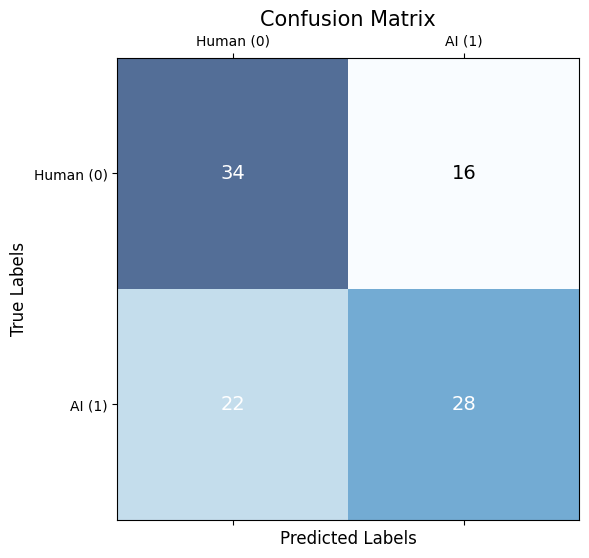

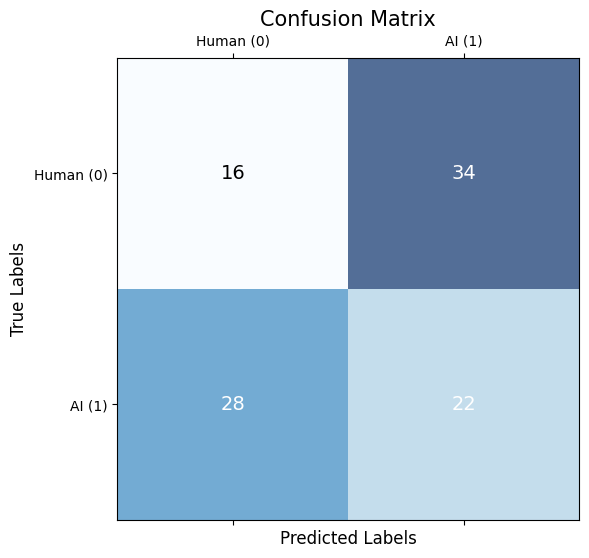

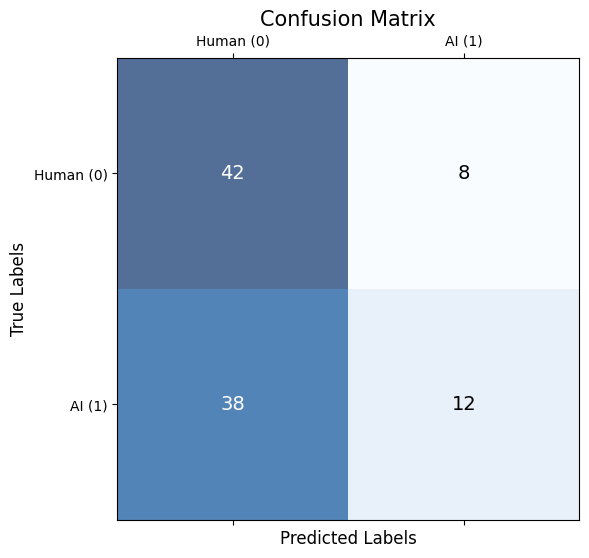

In [26]:
def plot_confusion_matrix(conf_matrix, class_labels):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(conf_matrix, cmap="Blues", alpha=0.7)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(
                x=j, y=i, s=conf_matrix[i, j], 
                va='center', ha='center', 
                fontsize=14, color="black" if conf_matrix[i, j] < np.max(conf_matrix) / 2 else "white"
            )

    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels)
    plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
    plt.title("Confusion Matrix", fontsize=15)
    plt.show()

# Define the class labels
class_labels = ['Human (0)', 'AI (1)']
plot_confusion_matrix(conf_matrix015inv, class_labels)
plot_confusion_matrix(conf_matrix015, class_labels)
plot_confusion_matrix(conf_matrix020, class_labels)